# EDA & Visualization

---
다시 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [1]:
!pip install pandas_profiling
!pip install mplfinance
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.8/679.8 kB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 45.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 87.6 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27096 sha256=0a5e386259e3873808ba6111c00dabb82c44d699083fd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 8.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import seaborn as sns
import pandas_profiling
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import mplfinance as mpf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

<ipython-input-2-395937c8dbce>:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [3]:
def feature_engineering(df):
  # 이동평균선 계산
  df['sma5'] = df['Close'].rolling(window=5).mean()
  df['sma20'] = df['Close'].rolling(window=20).mean()
  df['ema12'] = df['Close'].ewm(span=12, adjust=False).mean()
  df['ema26'] = df['Close'].ewm(span=26, adjust=False).mean()

  # MACD 계산
  df['macd'] = df['ema12'] - df['ema26']
  df['signal'] = df['macd'].ewm(span=9, adjust=False).mean()

  # RSI 계산
  delta = df['Close'].diff()
  gain, loss = delta.copy(), delta.copy()
  gain[gain < 0] = 0
  loss[loss > 0] = 0
  df['gain'] = gain
  df['loss'] = loss
  avg_gain = gain.rolling(window=14).mean()
  avg_loss = abs(loss.rolling(window=14).mean())
  rs = avg_gain / avg_loss
  df['rsi'] = 100 - (100 / (1 + rs))

  # Bollinger Bands 계산
  std = df['Close'].rolling(window=20).std()
  df['upper_band'] = df['sma20'] + 2 * std
  df['lower_band'] = df['sma20'] - 2 * std

  # 이동평균선 교차 계산
  diff = df['sma5'] - df['sma20']
  sign = np.sign(diff)
  df['cross'] = ((sign.shift(1) != sign) & (sign.shift(1).notnull())).astype(int)

  # gain, loss drop
  df.drop(['gain', 'loss'], axis=1, inplace=True)

  # target column ; 다음날의 종가 예측
  df['target_1d'] = df['Close'].shift(-1)

  # target column2 : 5일 후의 종가 예측
  df['target_5d'] = df['Close'].shift(-5)
  return df

In [4]:
# 데이터 불러오기, feature engineering 적용

decen = fdr.DataReader('MANA-USD').reset_index()
sandbox = fdr.DataReader('SAND-USD').reset_index()
orb = fdr.DataReader('ORB18839-USD').reset_index()

decen = feature_engineering(decen)
sandbox = feature_engineering(sandbox)
orb = feature_engineering(orb)

In [ ]:
decen.isnull().sum() # 결측치는 3개 모두 같다.

Date           0
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
sma5           4
sma20         19
ema12          0
ema26          0
macd           0
signal         0
rsi           14
upper_band    19
lower_band    19
cross          0
target_1d      1
target_5d      5
dtype: int64

In [ ]:
orb.cross.value_counts(normalize=True)

0    0.958442
1    0.041558
Name: cross, dtype: float64

In [ ]:
decen.cross.value_counts(normalize=True)

0    0.946438
1    0.053562
Name: cross, dtype: float64

In [ ]:
sandbox.cross.value_counts(normalize=True)

0    0.936082
1    0.063918
Name: cross, dtype: float64

In [ ]:
decen_profile = decen.profile_report()
sandbox_profile = sandbox.profile_report()
orb_profile = orb.profile_report()

decen_profile.to_file('decen_profile_report.html')
sandbox_profile.to_file('sandbox_profile_report.html')
orb_profile.to_file('orb_profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
decen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1979 non-null   datetime64[ns]
 1   Open        1979 non-null   float64       
 2   High        1979 non-null   float64       
 3   Low         1979 non-null   float64       
 4   Close       1979 non-null   float64       
 5   Adj Close   1979 non-null   float64       
 6   Volume      1979 non-null   int64         
 7   sma5        1975 non-null   float64       
 8   sma20       1960 non-null   float64       
 9   ema12       1979 non-null   float64       
 10  ema26       1979 non-null   float64       
 11  macd        1979 non-null   float64       
 12  signal      1979 non-null   float64       
 13  rsi         1965 non-null   float64       
 14  upper_band  1960 non-null   float64       
 15  lower_band  1960 non-null   float64       
 16  cross       1979 non-nul

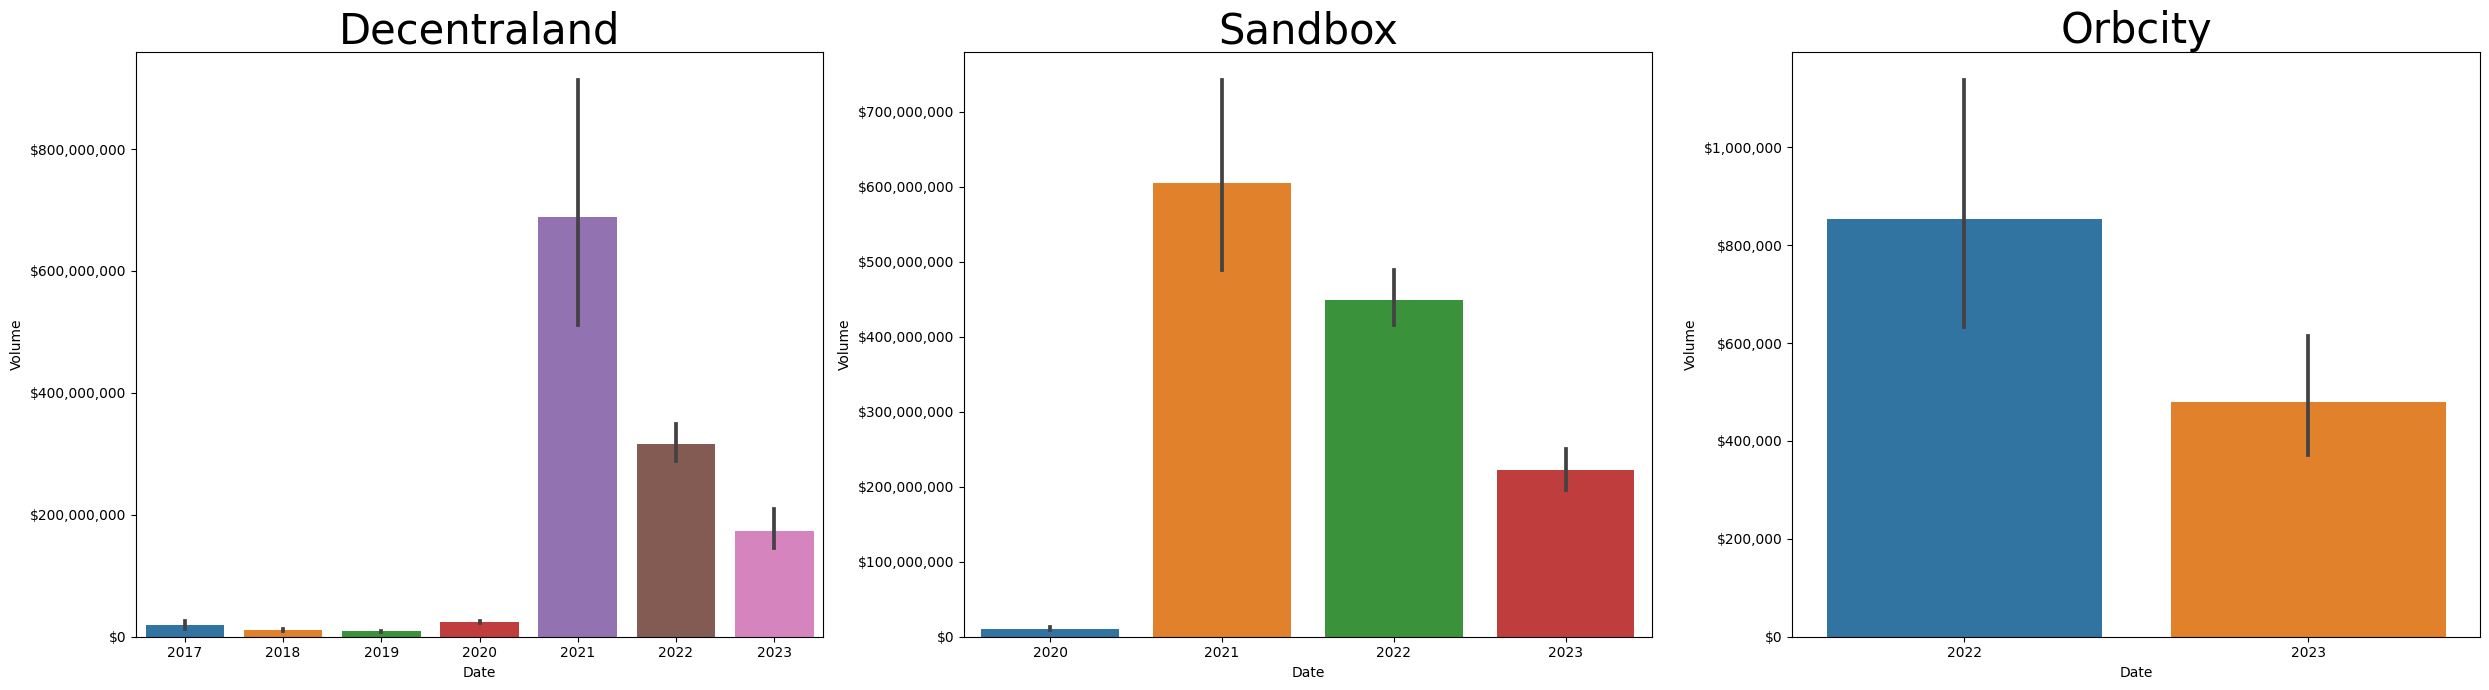

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(25, 7))

sns.barplot(x=decen['Date'].dt.year, y=decen['Volume'], ax=axs[0])
axs[0].set_title('Decentraland', fontsize=30)

sns.barplot(x=sandbox['Date'].dt.year, y=sandbox['Volume'], ax=axs[1])
axs[1].set_title('Sandbox', fontsize=30)

sns.barplot(x=orb['Date'].dt.year, y=orb['Volume'], ax=axs[2])
axs[2].set_title('Orbcity', fontsize=30)

def format_func(value, tick_number):
    return f'${int(value):,d}'

for ax in axs:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.tight_layout();

**연도별 판매량**
* Decentraland, Sandbox : 2021년부터 갑자기 흥행, 감소추세
* Orbcity : 2022년에 출시되자 마자 흥행, 감소추세


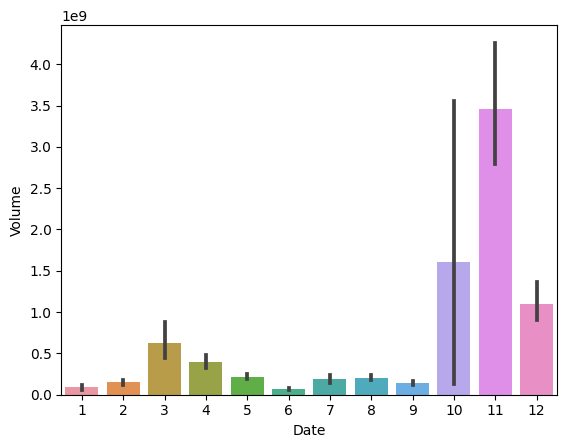

In [ ]:
decan_2021 = decen[decen['Date'].dt.year==2021]
sns.barplot(x=decan_2021['Date'].dt.month, y=decan_2021['Volume']);

In [9]:
# 결측치는 다 제거해주었다. (약 20개 정도도)
decen.dropna(inplace=True)
decen.reset_index(drop=True, inplace=True)

sandbox.dropna(inplace=True)
sandbox.reset_index(drop=True, inplace=True)

orb.dropna(inplace=True)
orb.reset_index(drop=True, inplace=True)

decen.shape, sandbox.shape, orb.shape

((1956, 19), (947, 19), (361, 19))

In [10]:
# decen의 2021년도 흥행 트렌드를 봤을 때, sandbox의 시작년도 이전 것은 drop하겠다.
sandbox.loc[0, 'Date']

Timestamp('2020-09-02 00:00:00')

In [11]:
decen = decen[decen['Date'] >= sandbox.loc[0, 'Date']]
decen.reset_index(drop=True, inplace=True)

In [12]:
decen.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
sma5          0
sma20         0
ema12         0
ema26         0
macd          0
signal        0
rsi           0
upper_band    0
lower_band    0
cross         0
target_1d     0
target_5d     0
dtype: int64

In [13]:
decen.shape, sandbox.shape, orb.shape # sandbox 4월 5일 데이터 없음.

((947, 19), (947, 19), (361, 19))

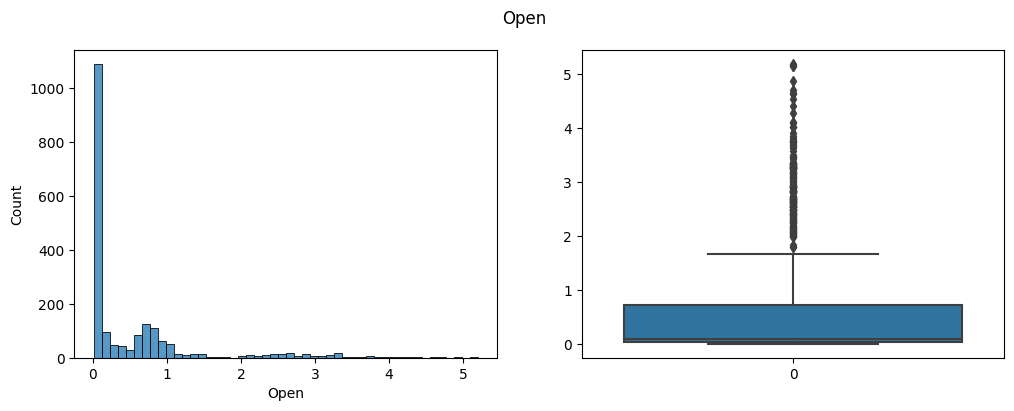

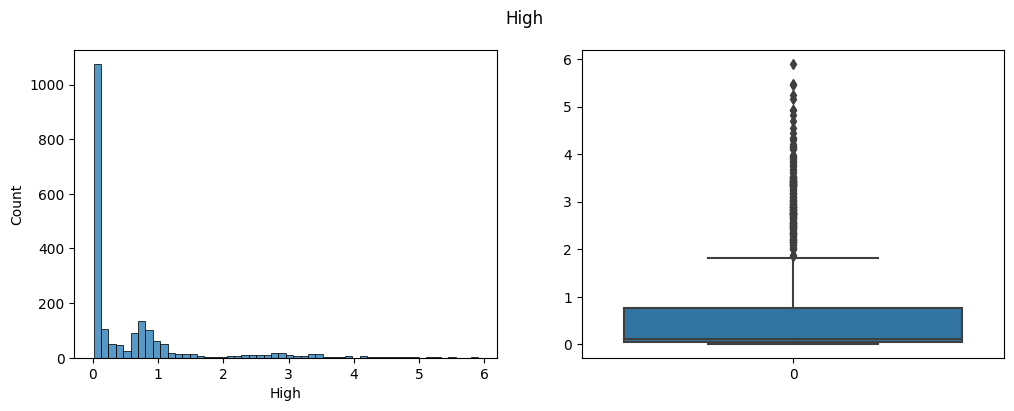

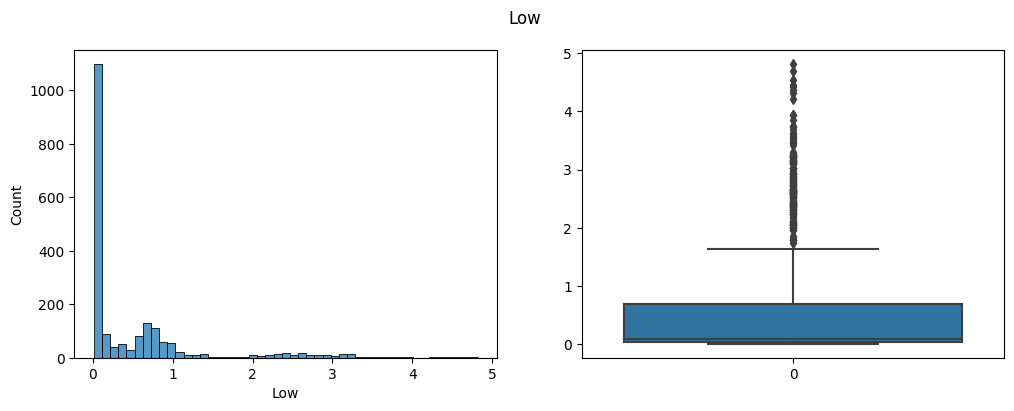

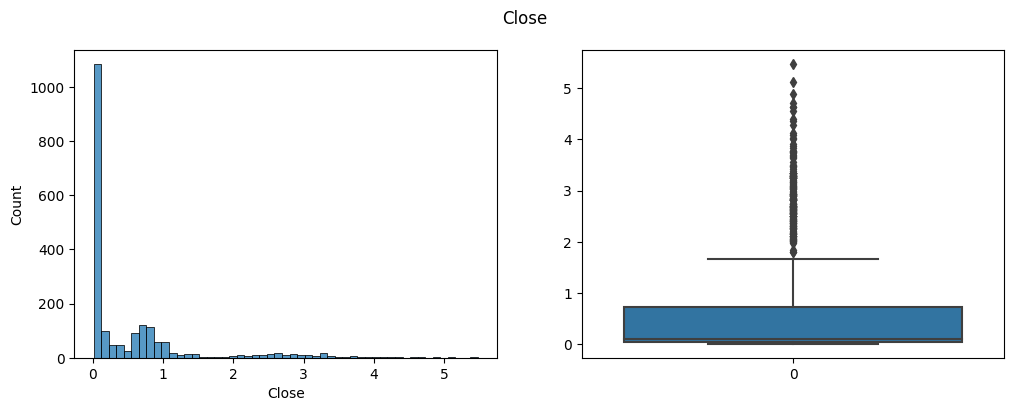

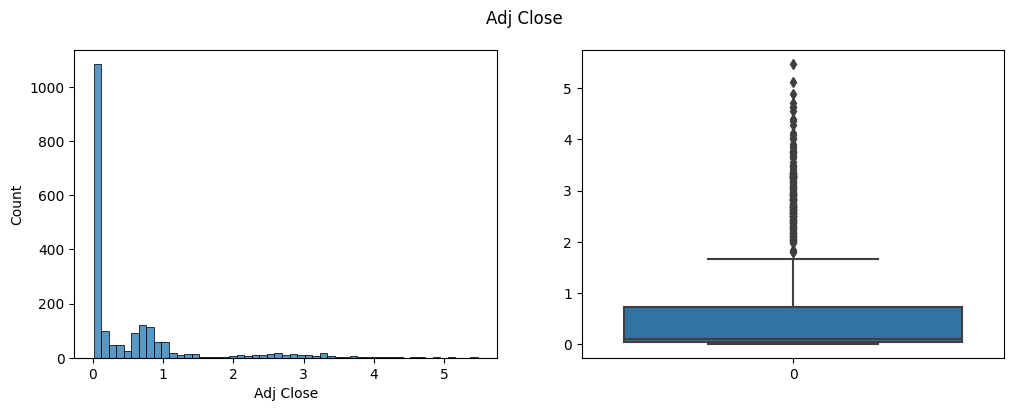

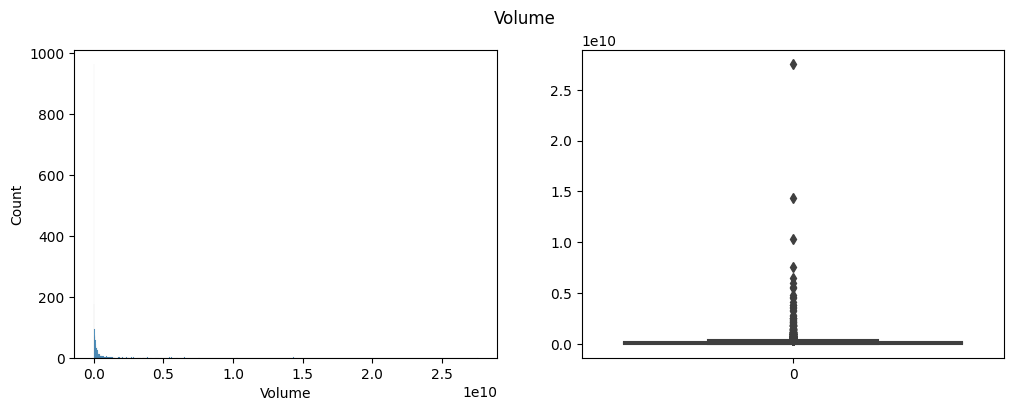

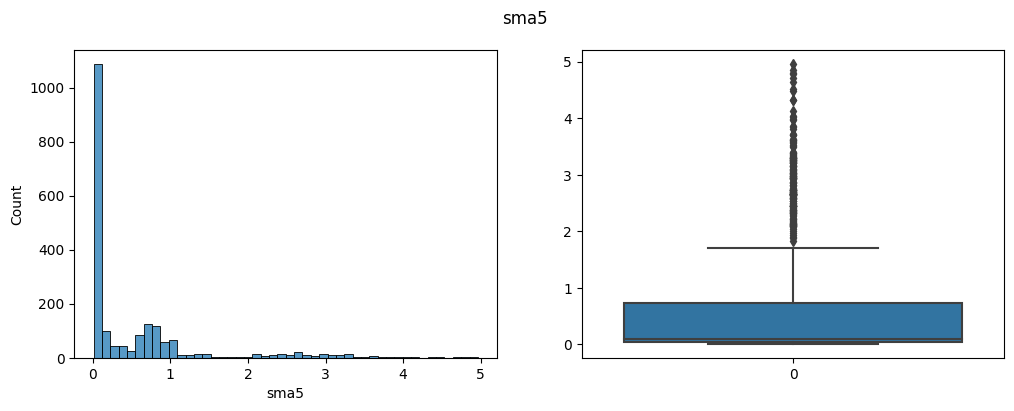

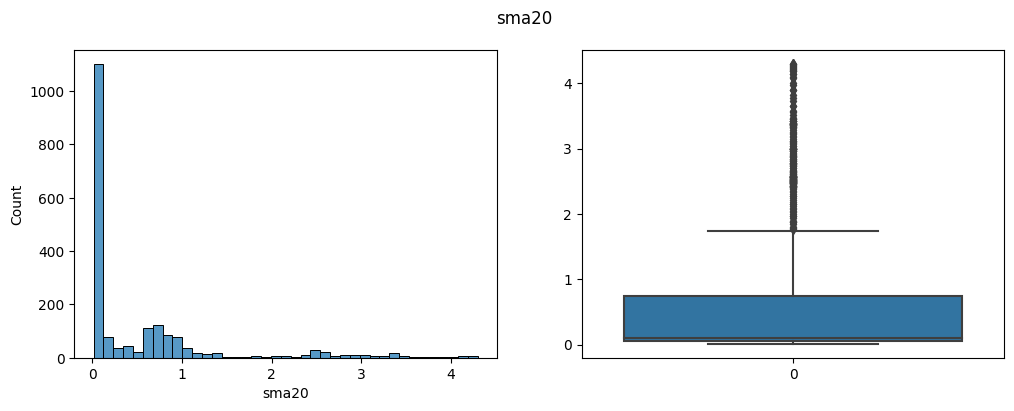

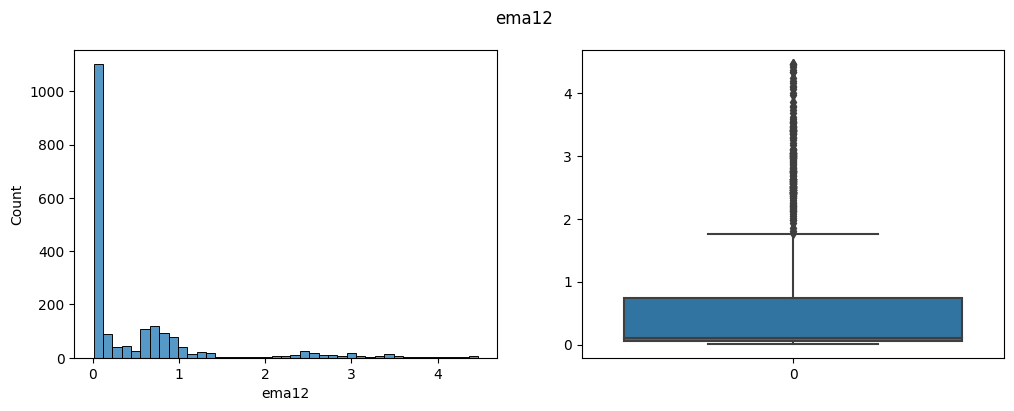

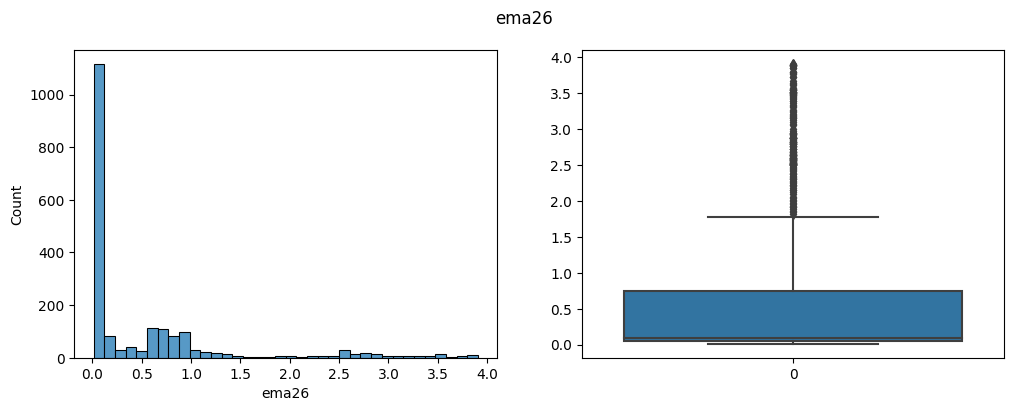

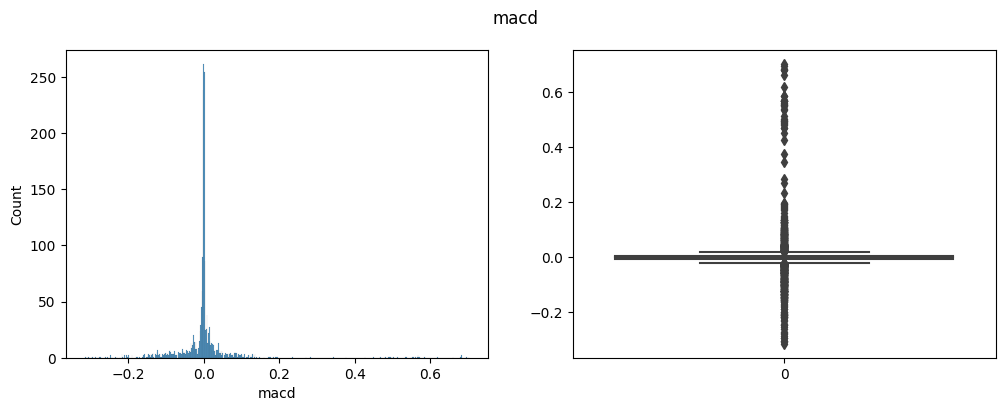

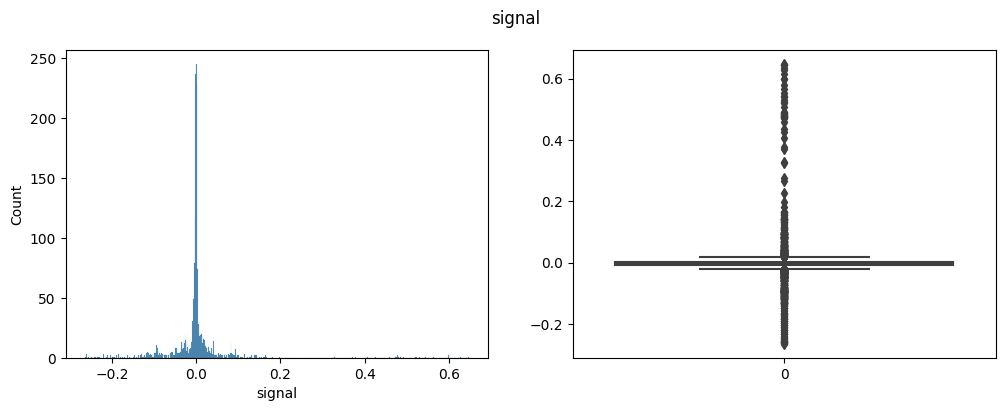

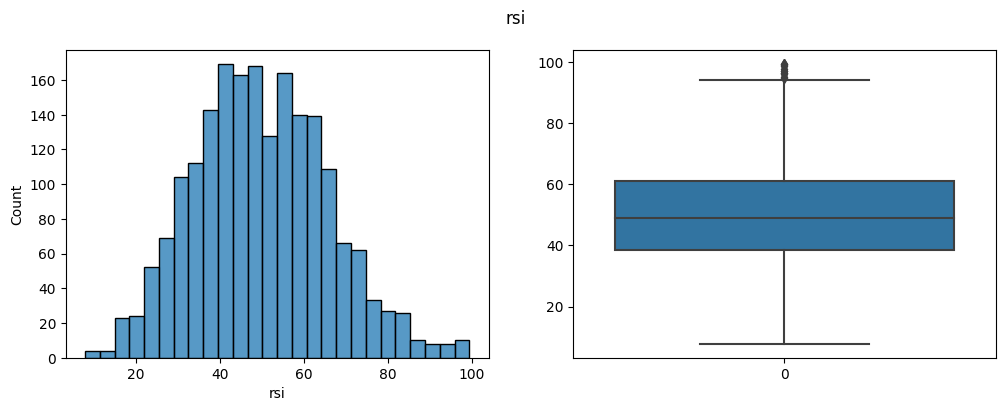

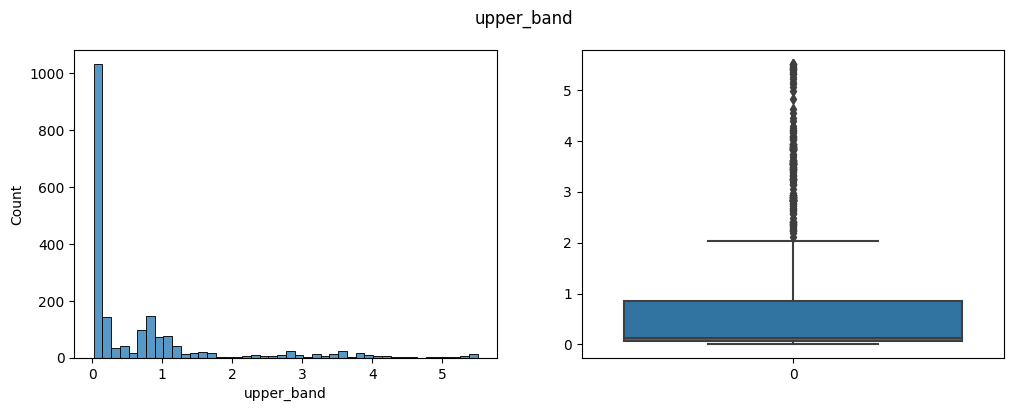

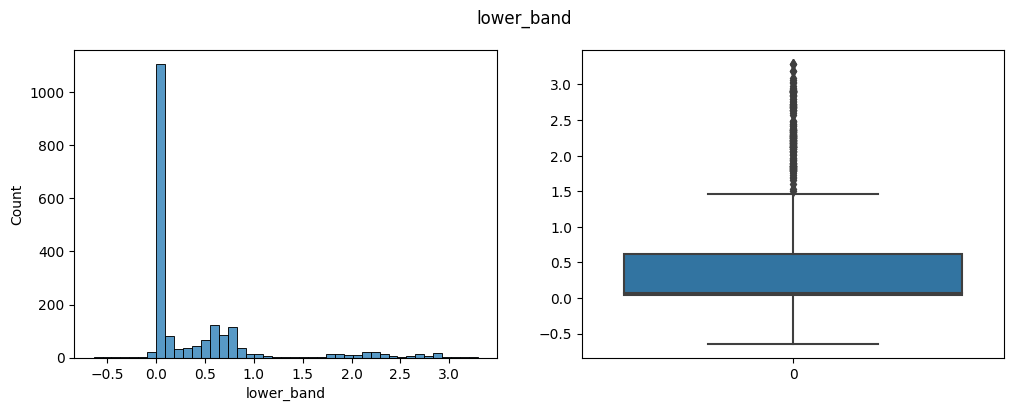

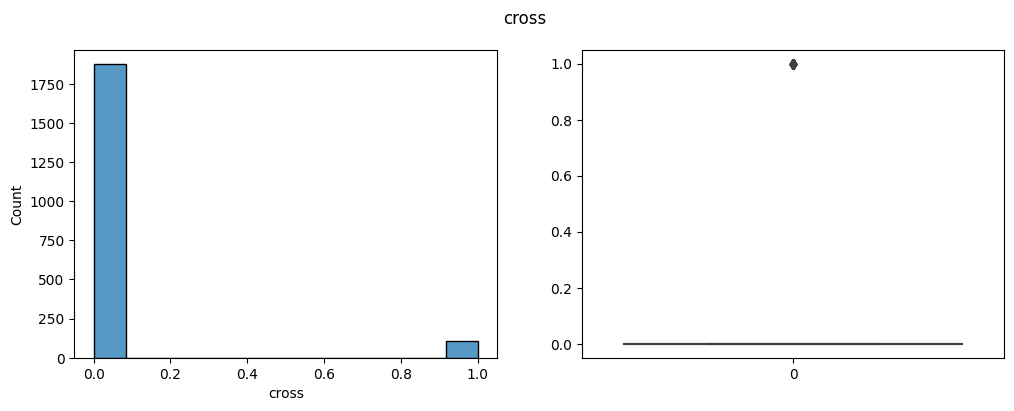

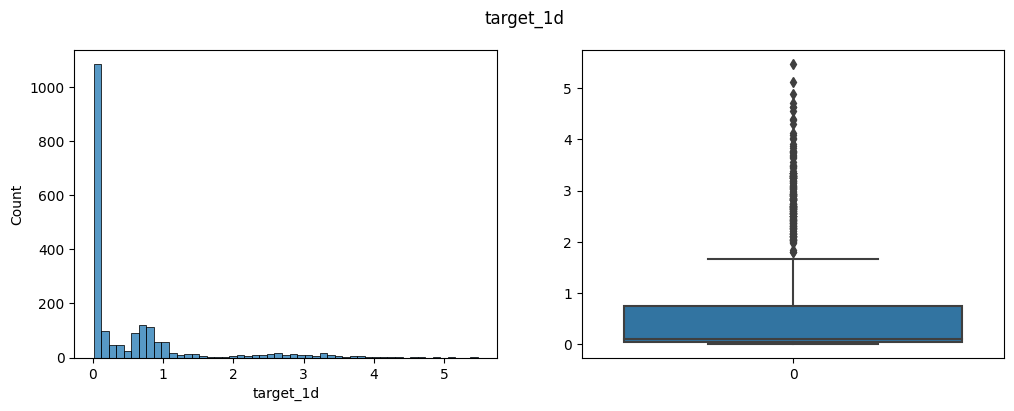

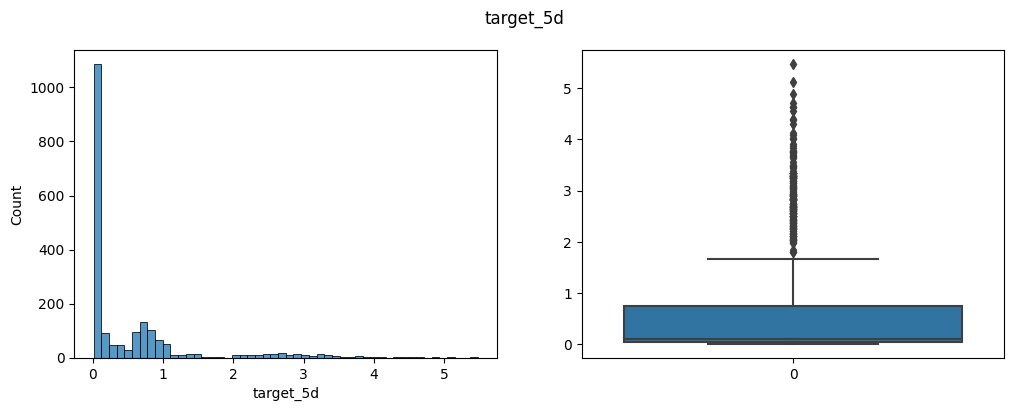

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임에서 feature 선택
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
            'sma5', 'sma20', 'ema12', 'ema26', 'macd', 'signal', 'rsi',
            'upper_band', 'lower_band', 'cross', 'target_1d', 'target_5d']

# 히스토그램과 박스플롯으로 분포 확인
for feature in features:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    sns.histplot(decen[feature], ax=ax[0])
    sns.boxplot(decen[feature], ax=ax[1])
    fig.suptitle(feature)
    plt.show()


In [ ]:
decen.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sma5,sma20,ema12,ema26,macd,signal,rsi,upper_band,lower_band,cross,target_1d,target_5d
0,2020-09-02,0.100694,0.104012,0.091389,0.100446,0.100446,60876653,0.102387,0.095670,0.097948,0.090376,0.007572,0.008414,64.688549,0.108853,0.082487,0,0.082960,0.076879
1,2020-09-03,0.100560,0.101295,0.082528,0.082960,0.082960,51053790,0.097292,0.095054,0.095642,0.089826,0.005816,0.007894,44.008498,0.109412,0.080695,0,0.088212,0.074365
2,2020-09-04,0.082707,0.090225,0.081716,0.088212,0.088212,52366483,0.094249,0.094541,0.094499,0.089707,0.004792,0.007274,45.729136,0.109117,0.079965,1,0.078609,0.077438
3,2020-09-05,0.088227,0.089837,0.072696,0.078609,0.078609,56039022,0.090226,0.093541,0.092055,0.088885,0.003170,0.006453,38.296774,0.109610,0.077472,0,0.078271,0.082078
4,2020-09-06,0.078609,0.081143,0.073036,0.078271,0.078271,37722033,0.085700,0.092675,0.089934,0.088099,0.001835,0.005529,40.532605,0.110089,0.075261,0,0.076879,0.085089


In [ ]:
sandbox.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sma5,sma20,ema12,ema26,macd,signal,rsi,upper_band,lower_band,cross,target_1d,target_5d
0,2020-09-02,0.059742,0.060859,0.051136,0.059072,0.059072,10893388.0,0.065662,0.057614,0.061765,0.060892,0.000873,-0.000253,54.453082,0.076619,0.038610,0,0.044335,0.037924
1,2020-09-03,0.058932,0.059548,0.043842,0.044335,0.044335,5884472.0,0.060027,0.056549,0.059083,0.059666,-0.000582,-0.000319,44.912208,0.076041,0.037057,0,0.045431,0.049850
2,2020-09-04,0.043963,0.047490,0.038952,0.045431,0.045431,5619298.0,0.055785,0.056272,0.056983,0.058611,-0.001628,-0.000581,50.718698,0.076249,0.036295,1,0.037567,0.048329
3,2020-09-05,0.045298,0.047044,0.035231,0.037567,0.037567,4072606.0,0.049261,0.055108,0.053996,0.057052,-0.003056,-0.001076,45.271799,0.076617,0.033599,0,0.040924,0.049563
4,2020-09-06,0.037562,0.042555,0.033405,0.040924,0.040924,4407990.0,0.045466,0.054455,0.051985,0.055858,-0.003873,-0.001635,48.299447,0.076881,0.032028,0,0.037924,0.051795


In [ ]:
orb.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sma5,sma20,ema12,ema26,macd,signal,rsi,upper_band,lower_band,cross,target_1d,target_5d
0,2022-04-10,0.437217,0.437499,0.384871,0.388640,0.388640,3495446.0,0.412537,0.423458,0.417801,0.439934,-0.022133,-0.025585,49.980768,0.529546,0.317370,0,0.366286,0.348381
1,2022-04-11,0.388546,0.394728,0.364913,0.366286,0.366286,2455043.0,0.410989,0.415550,0.409876,0.434479,-0.024603,-0.025388,46.789430,0.513182,0.317918,0,0.379134,0.347329
2,2022-04-12,0.366440,0.392020,0.353462,0.379134,0.379134,2169054.0,0.402472,0.409803,0.405146,0.430379,-0.025233,-0.025357,52.518949,0.501313,0.318293,0,0.361330,0.336730
3,2022-04-13,0.379150,0.382842,0.343605,0.361330,0.361330,2731981.0,0.386532,0.403049,0.398405,0.425264,-0.026859,-0.025658,51.596167,0.487299,0.318800,0,0.358279,0.336562
4,2022-04-14,0.361345,0.365375,0.349468,0.358279,0.358279,2325314.0,0.370734,0.397076,0.392232,0.420303,-0.028071,-0.026140,50.778370,0.475787,0.318366,0,0.348381,0.345708


In [ ]:
decen_eda = decen.set_index('Date')
sandbox_eda = sandbox.set_index('Date')
orb_eda = orb.set_index('Date')

/usr/local/lib/python3.9/dist-packages/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


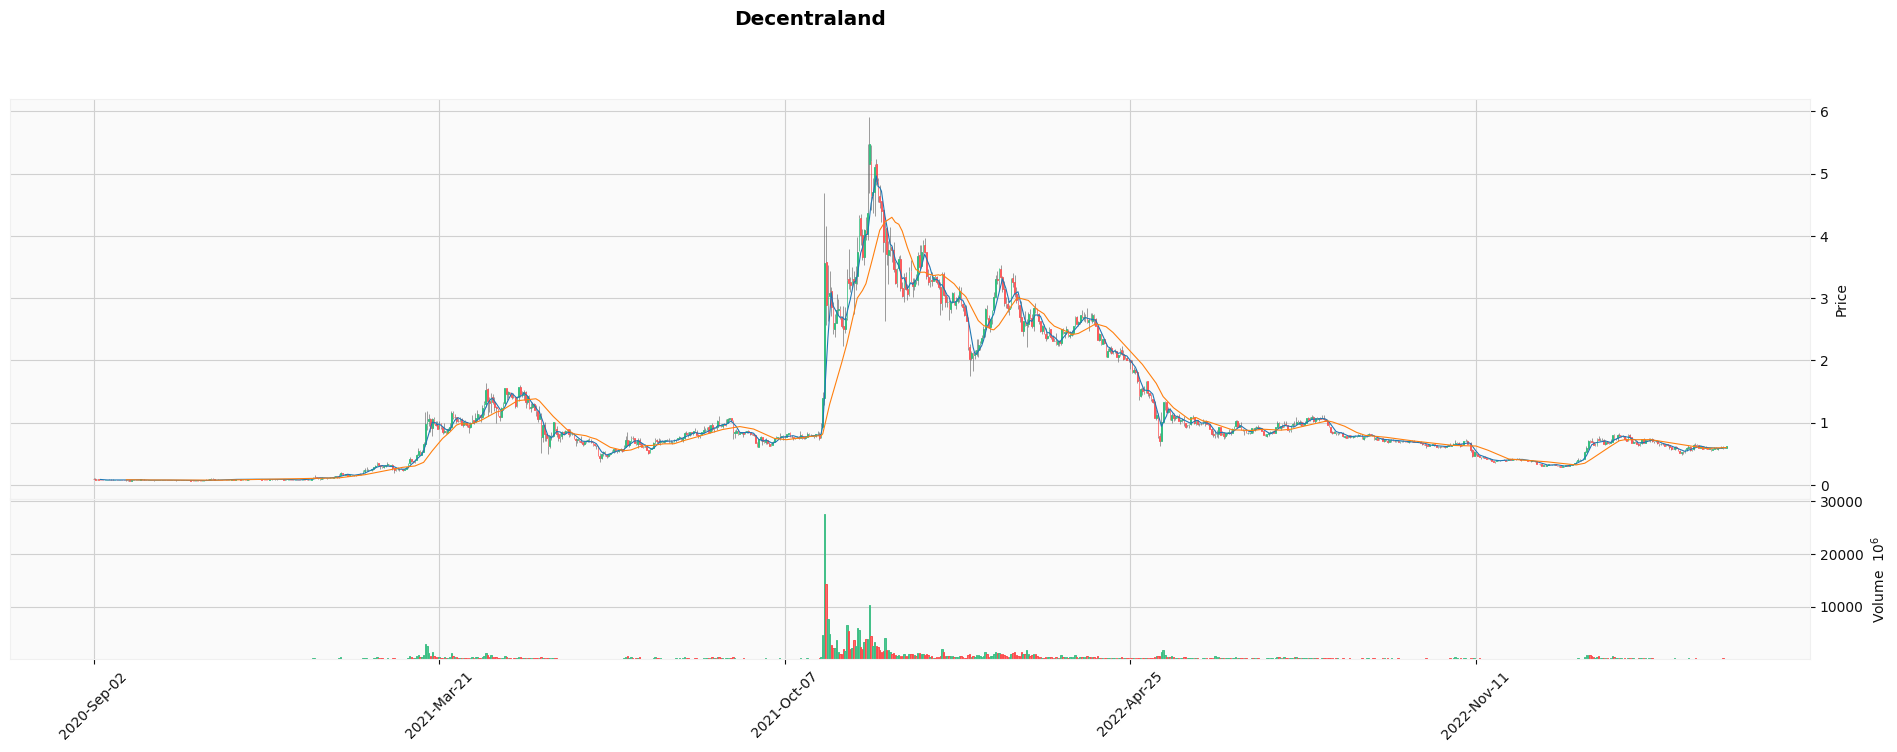

<Figure size 640x480 with 0 Axes>

In [ ]:
mpf.plot(decen_eda, type='candle', volume=True, mav=(5, 20), title='Decentraland',
         figsize=(25,8),  style='yahoo') # yahoo : 선 두께 두꺼운 스타일
plt.tight_layout();

/usr/local/lib/python3.9/dist-packages/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


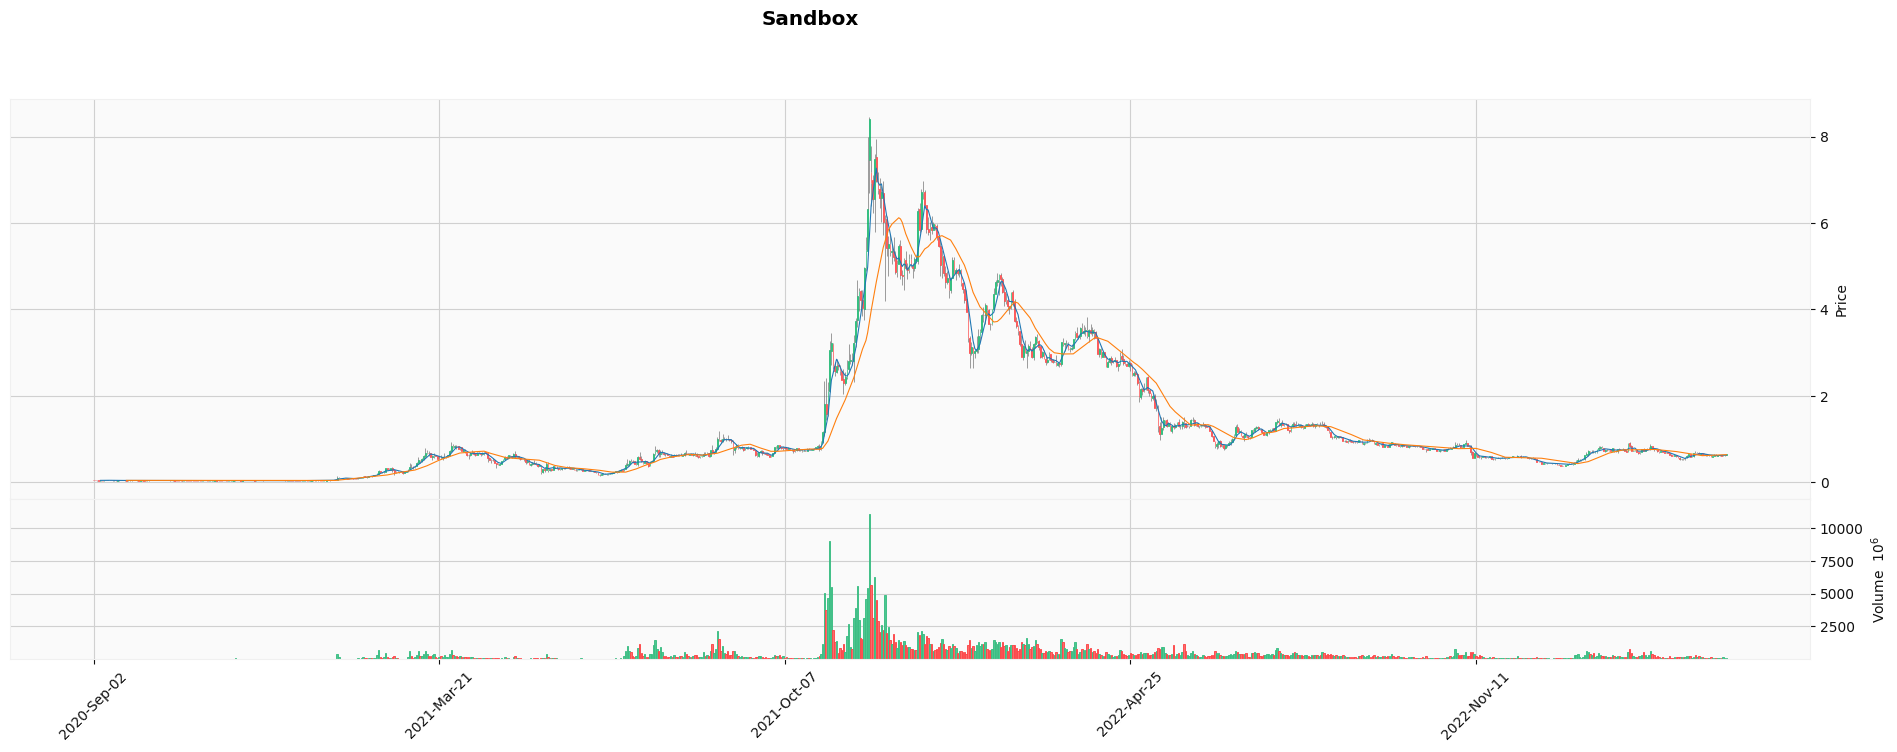

<Figure size 640x480 with 0 Axes>

In [ ]:
mpf.plot(sandbox_eda, type='candle', volume=True, mav=(5, 20), title='Sandbox',
         figsize=(25,8),  style='yahoo') 
plt.tight_layout();

In [ ]:
sandbox_eda[sandbox_eda.Volume==sandbox_eda.Volume.max()]['Volume']

Date
2021-11-25    11077988546
Name: Volume, dtype: int64

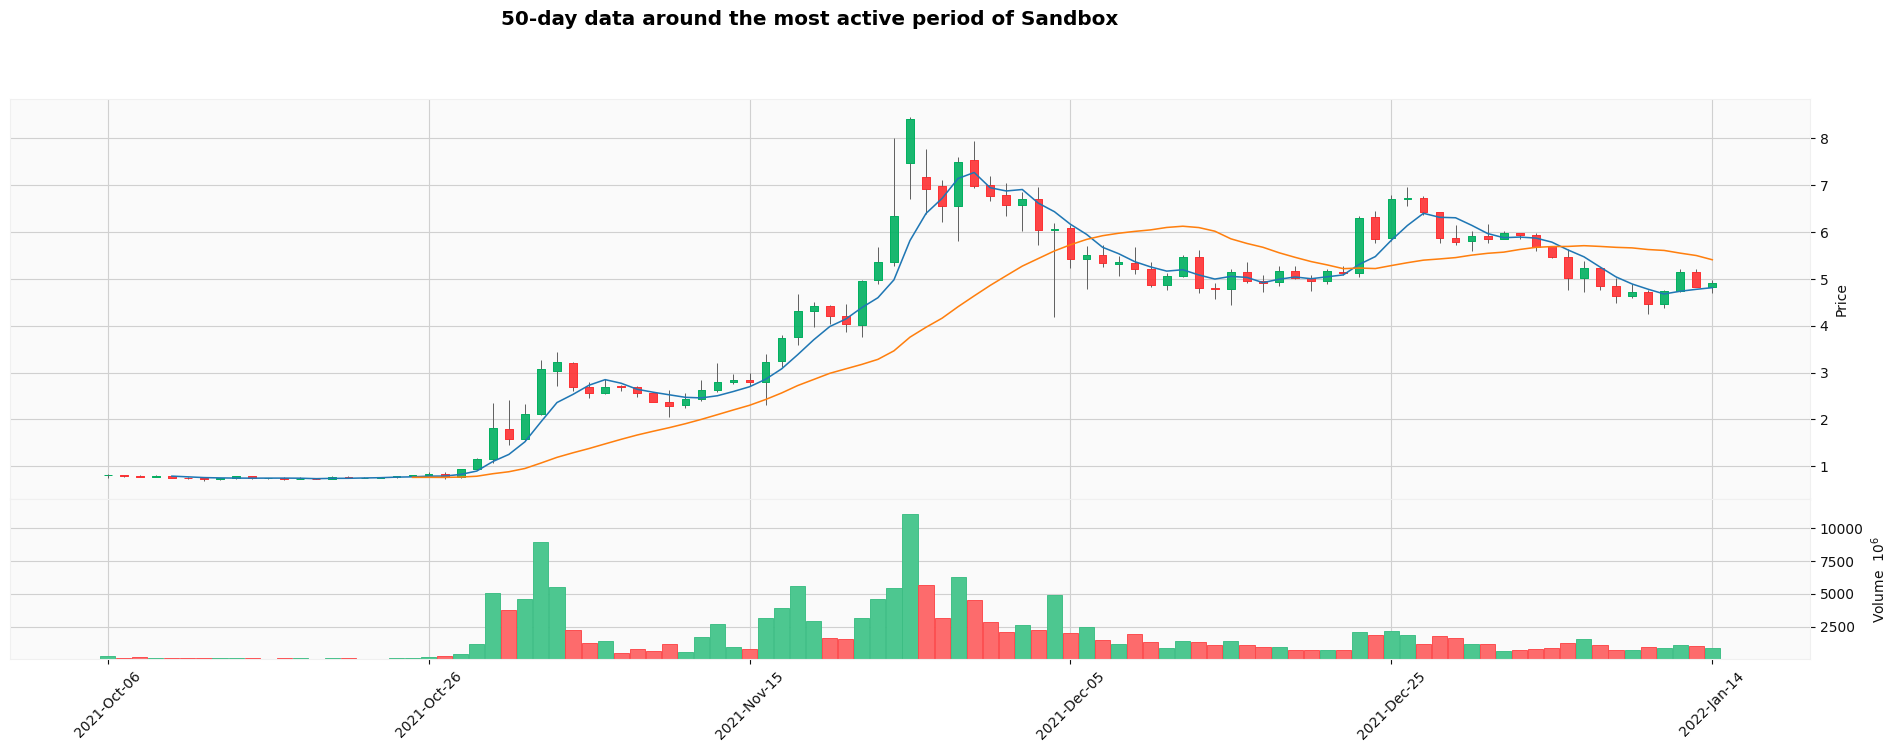

<Figure size 640x480 with 0 Axes>

In [ ]:
# 가장 활발하게 거래되었을 때를 자세히 봐보자.
# max_sandbox_date 이후로 50일을 더한 날짜 구하기
max_sandbox_date = sandbox_eda[sandbox_eda.Volume==sandbox_eda.Volume.max()].index[0]
end_date = max_sandbox_date + pd.Timedelta(days=50)

# 이전 50일을 뺀 날짜 구하기
start_date = max_sandbox_date - pd.Timedelta(days=50)

# 해당 기간에 해당하는 데이터 가져오기
sandbox_subset = sandbox_eda[(sandbox_eda.index >= start_date) & (sandbox_eda.index <= end_date)]

mpf.plot(sandbox_subset, type='candle', volume=True, mav=(5, 20), title='50-day data around the most active period of Sandbox',
         figsize=(25,8),  style='yahoo') 
plt.tight_layout();

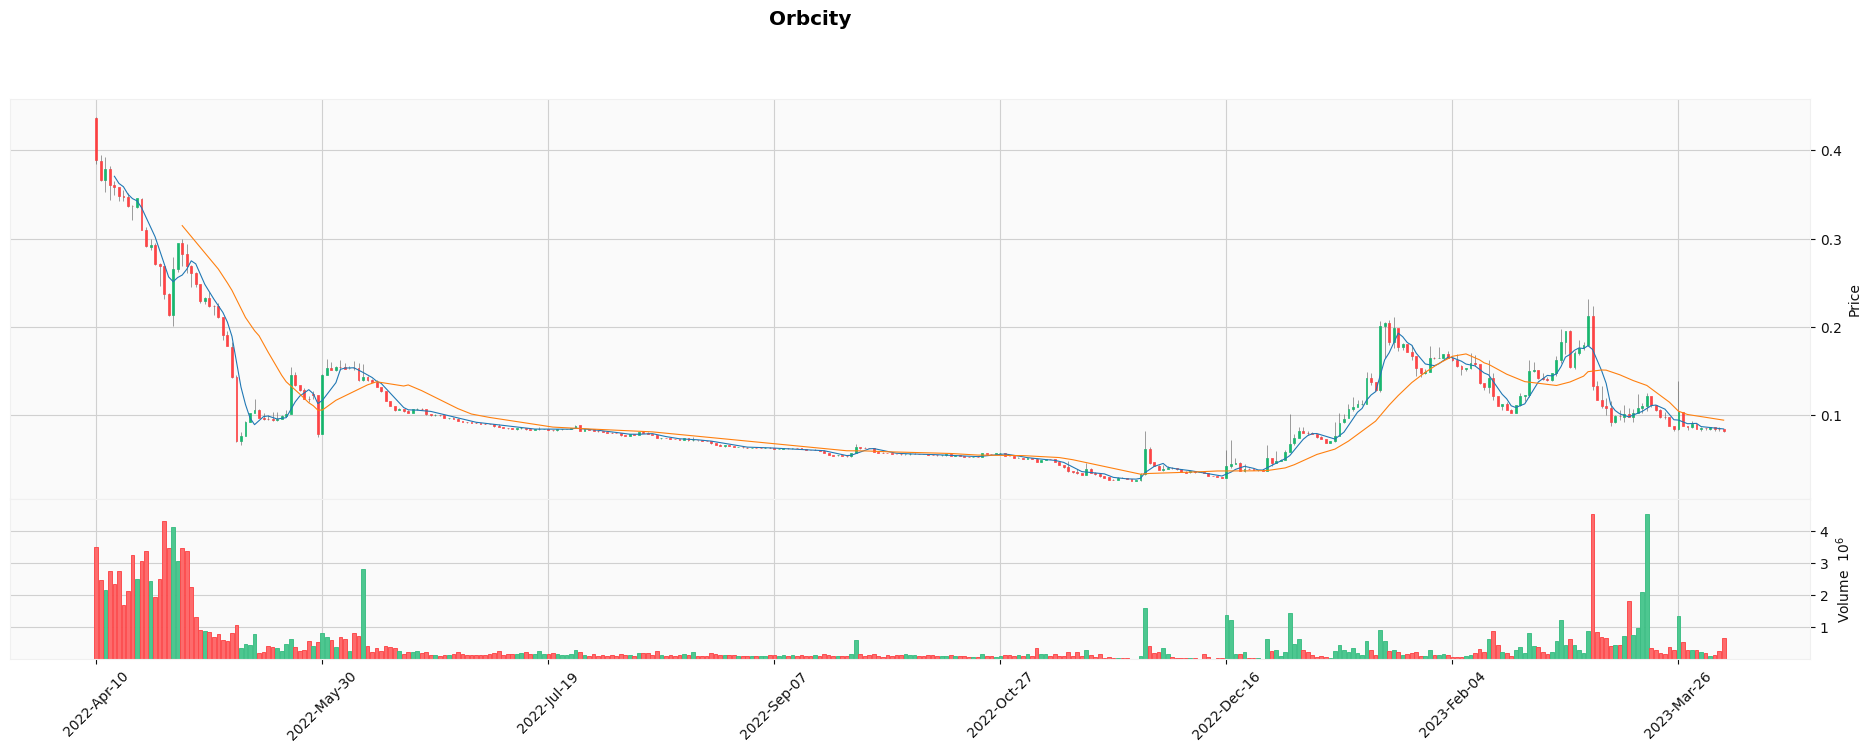

<Figure size 640x480 with 0 Axes>

In [ ]:
mpf.plot(orb_eda, type='candle', volume=True, mav=(5, 20), title='Orbcity',
         figsize=(25,8),  style='yahoo') 
plt.tight_layout();

In [ ]:
decen.describe()

,Open,High,Low,Close,Adj Close,Volume,sma5,sma20,ema12,ema26,macd,signal,rsi,upper_band,lower_band,cross,target_1d,target_5d
count,946.000000,946.000000,946.000000,946.000000,946.000000,9.460000e+02,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000
mean,1.065147,1.121837,1.008227,1.064719,1.064719,4.093199e+08,1.063658,1.059738,1.061827,1.058001,0.003826,0.003893,49.054140,1.316778,0.802699,0.049683,1.065247,1.067445
std,1.010171,1.072479,0.949114,1.007094,1.007094,1.253022e+09,1.001910,0.988260,0.988921,0.967214,0.132875,0.125897,16.241604,1.259446,0.782019,0.217404,1.006719,1.005135
min,0.062720,0.063779,0.059712,0.062720,0.062720,5.119693e+06,0.063743,0.069924,0.066546,0.070079,-0.315543,-0.264902,7.913474,0.079835,-0.641505,0.000000,0.062720,0.062720
25%,0.412743,0.423367,0.400253,0.412751,0.412751,7.235620e+07,0.409473,0.404492,0.411980,0.442838,-0.045771,-0.042145,37.915805,0.520187,0.269772,0.000000,0.414186,0.420140
50%,0.756080,0.786024,0.718728,0.755645,0.755645,1.571651e+08,0.766203,0.752825,0.764365,0.767408,-0.002114,-0.002373,48.123104,0.866640,0.627534,0.000000,0.755645,0.755645
75%,1.095052,1.176381,1.044364,1.094558,1.094558,3.351224e+08,1.083079,1.151313,1.152990,1.169825,0.023811,0.022804,60.103553,1.542101,0.841012,0.000000,1.094558,1.094558
max,5.199132,5.902317,4.820426,5.479181,5.479181,2.757404e+10,4.963699,4.298007,4.466525,3.906485,0.703187,0.648418,99.365458,5.510574,3.293981,1.000000,5.479181,5.479181


# Decentraland -  Modeling

## LSTM

1일 뒤 예측

In [ ]:
target = 'target_1d'
x = decen.drop(columns=[target, 'target_5d'], axis=1)
y = decen[target]

# Convert to Unix timestamp
x['Date'] = x['Date'].astype(np.int64) // 10**9

# Apply MinMaxScaler to all columns except 'Date'
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x.drop(columns=['Date']))

x_train, x_test = x_scaled[0:int(len(x_scaled)*0.8)], x_scaled[int(len(x_scaled)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]

# Reshape input data to be 3-dimensional
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# Initialize model
lstm = Sequential()
lstm.add(LSTM(50, activation='tanh', input_shape=(1, x_train.shape[2])))
lstm.add(Dense(16, activation="relu"))
lstm.add(Dense(1))

# Compile model
lstm.compile(loss='mse', optimizer='adam')

# Fit model to training data
lstm.fit(x_train, y_train, epochs=50, batch_size=64, verbose=0) 

# Make predictions on test set
y_pred_lstm = lstm.predict(x_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred_lstm)
rmse = mean_squared_error(y_test, y_pred_lstm, squared=False)
r2 = r2_score(y_test, y_pred_lstm)
max_err = max_error(y_test, y_pred_lstm)

# Print performance metrics
print('\nLSTM 다음 날 종가 예측')
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Max Error: {max_err:.4f}")


6/6 [==============================] - 1s 3ms/step

LSTM 다음 날 종가 예측
Mean Absolute Error: 0.0347
Root Mean Squared Error: 0.0433
R-squared: 0.9082
Max Error: 0.1469


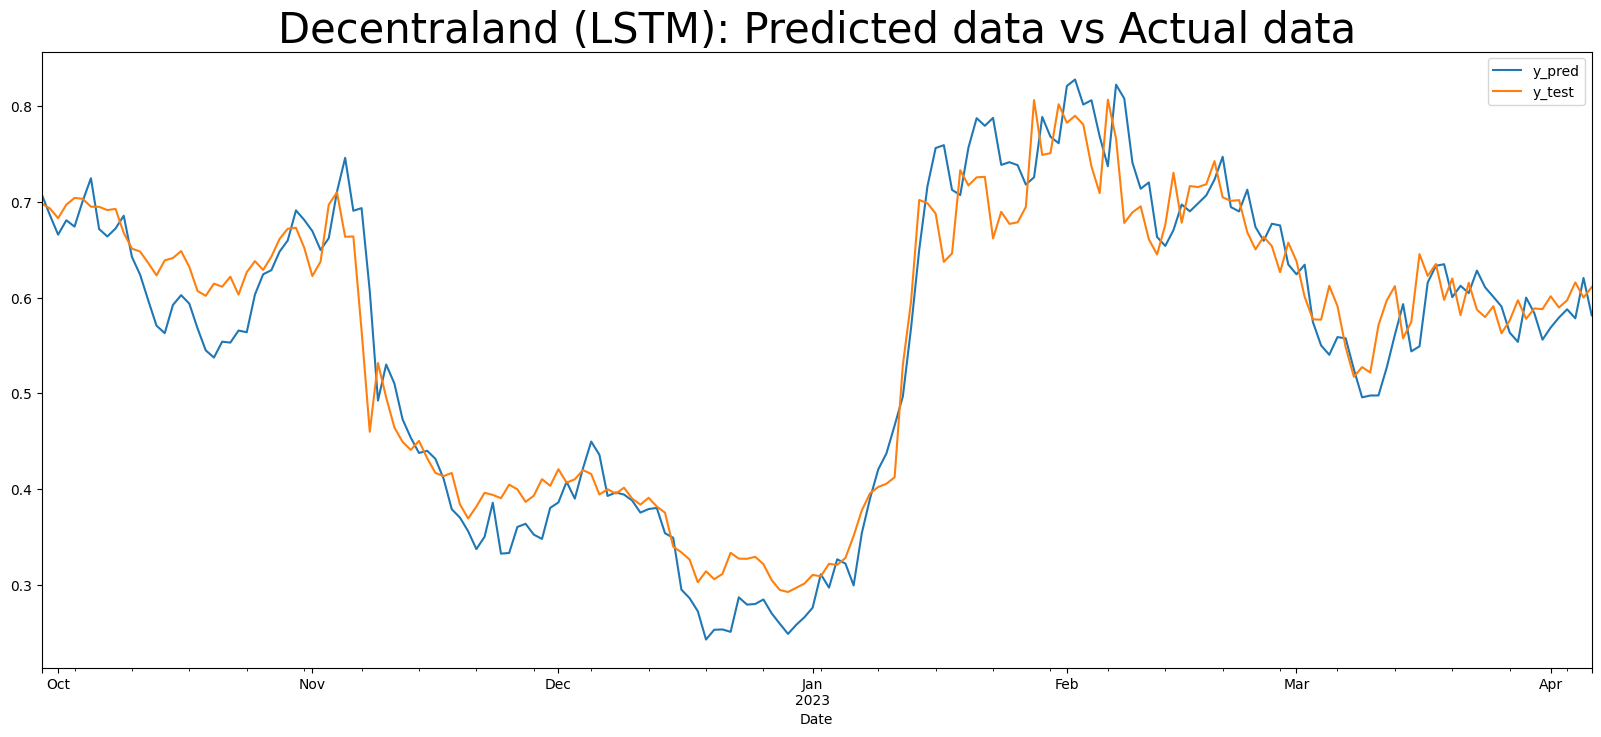

In [ ]:
date = pd.to_datetime(x['Date'], unit='s')[len(x_train):]
results = pd.DataFrame({'Date':date, 'y_pred':y_pred_lstm.reshape(-1), 'y_test':y_test})
results.set_index('Date', inplace=True)

results.plot(figsize=(20,8))
plt.title('Decentraland (LSTM): Predicted data vs Actual data',fontsize=30);

5일 후 예측

In [ ]:
target = 'target_5d'
x = decen.drop(columns=[target, 'target_1d'], axis=1)
y = decen[target]

# Convert to Unix timestamp
x['Date'] = x['Date'].astype(np.int64) // 10**9

# Apply MinMaxScaler to all columns except 'Date'
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x.drop(columns=['Date']))

x_train, x_test = x_scaled[0:int(len(x_scaled)*0.8)], x_scaled[int(len(x_scaled)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]

# Reshape input data to be 3-dimensional
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# Initialize model
lstm2 = Sequential()
lstm2.add(LSTM(50, activation='tanh', input_shape=(1, x_train.shape[2])))
lstm2.add(Dense(16, activation="relu"))
lstm2.add(Dense(1))

# Compile model
lstm2.compile(loss='mse', optimizer='adam')

# Fit model to training data
lstm2.fit(x_train, y_train, epochs=50, batch_size=64, verbose=0) 

# Make predictions on test set
y_pred_lstm2 = lstm2.predict(x_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred_lstm2)
rmse = mean_squared_error(y_test, y_pred_lstm2, squared=False)
r2 = r2_score(y_test, y_pred_lstm2)
max_err = max_error(y_test, y_pred_lstm2)

# Print performance metrics
print('\n 5일 후 종가 예측')
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Max Error: {max_err:.4f}")


6/6 [==============================] - 0s 3ms/step

 5일 후 종가 예측
Mean Absolute Error: 0.0623
Root Mean Squared Error: 0.0846
R-squared: 0.6449
Max Error: 0.2767


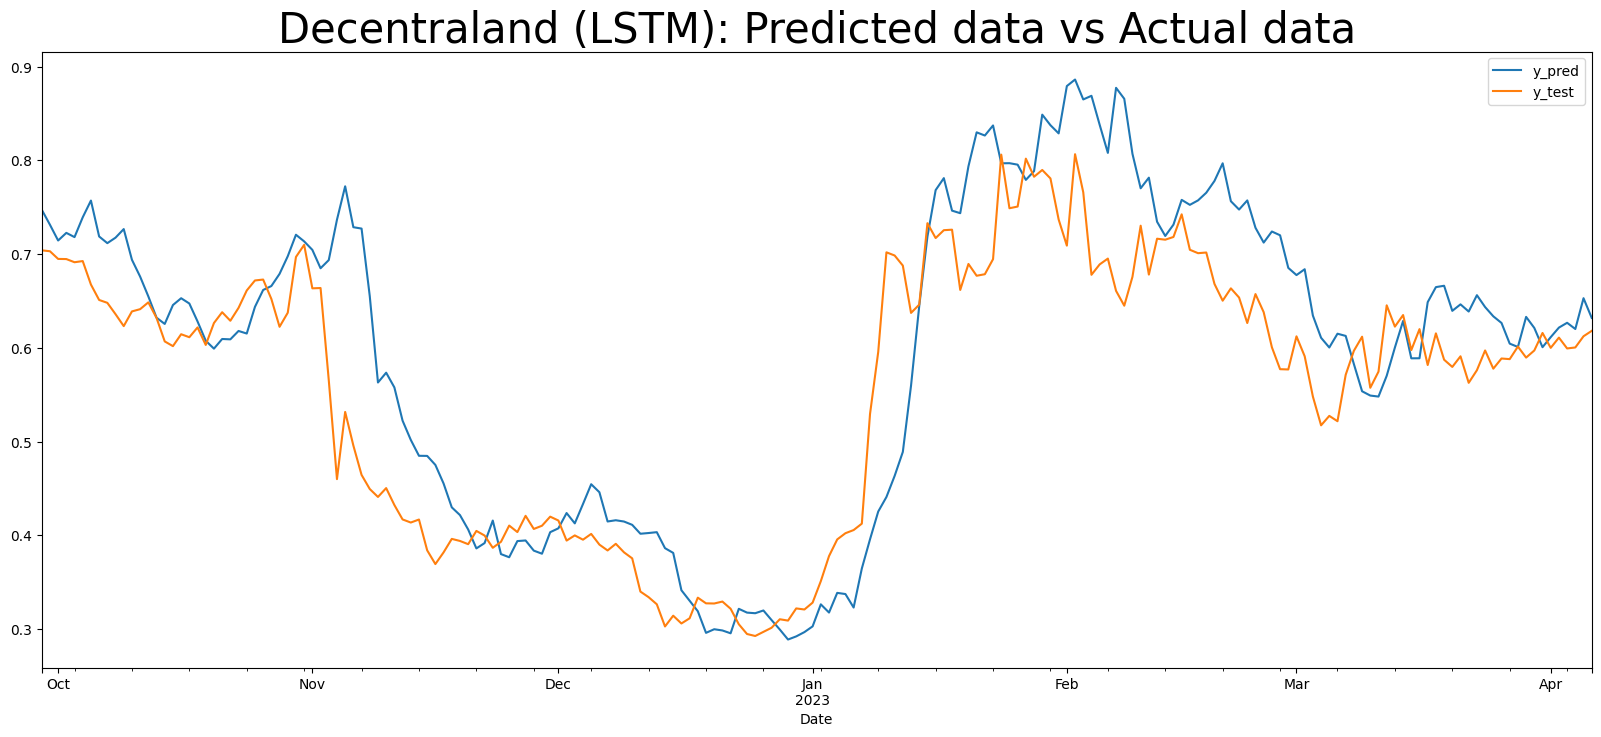

In [ ]:
date = pd.to_datetime(x['Date'], unit='s')[len(x_train):]
results = pd.DataFrame({'Date':date, 'y_pred':y_pred_lstm2.reshape(-1), 'y_test':y_test})
results.set_index('Date', inplace=True)

results.plot(figsize=(20,8))
plt.title('Decentraland (LSTM): Predicted data vs Actual data',fontsize=30);

## RandomForest

<Axes: >

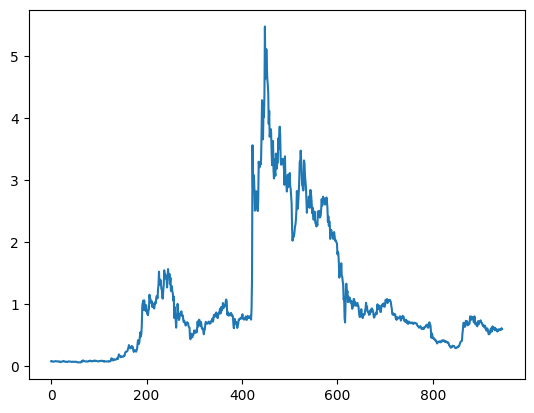

In [ ]:
# 타겟은 정규분포 형태이다.
decen['target_1d'].plot()

> 2년치 과거 데이터 -> 7개월 테스트 데이터 예측

1일 후 데이터 예측

In [ ]:
target='target_1d'
x = decen.drop(columns=[target, 'target_5d'], axis=1)
y = decen[target]

# Convert to Unix timestamp
x['Date'] = x['Date'].astype(np.int64) // 10**9

x_train, x_test = x[0:int(len(x)*0.8)], x[int(len(x)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((757, 17), (190, 17), (757,), (190,))

In [ ]:
# 기준 모델 : 평균 사용 (모델 예측의 하한선)
base = [y_train.mean()] * len(y_train)
base_mae = mean_absolute_error(y_train, base)
base_rmse = mean_squared_error(y_train, base, squared=False)

print('MAE of base model', base_mae)
print('RMSE of bse model', base_rmse)

MAE of base model 0.8512701293920765
RMSE of bse model 1.0862538137472713


In [ ]:
rf1 = RandomForestRegressor(criterion='squared_error',
                              min_samples_split=3,
                              random_state=42,
                              bootstrap=True,
                              oob_score=True,
                              max_features='sqrt')
param_grid = {
    'n_estimators': [1000, 1100, 1200],
    'max_depth': [8,9,10],
    'min_samples_leaf':[2,3,4]
}
grid_search = GridSearchCV(estimator=rf1, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
y_pred_rf = best_model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred_rf)
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
r2 = r2_score(y_test, y_pred_rf)
max_err = max_error(y_test, y_pred_rf)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Max Error: {max_err:.4f}")

Mean Absolute Error: 0.0510
Root Mean Squared Error: 0.0623
R-squared: 0.8104
Max Error: 0.1733


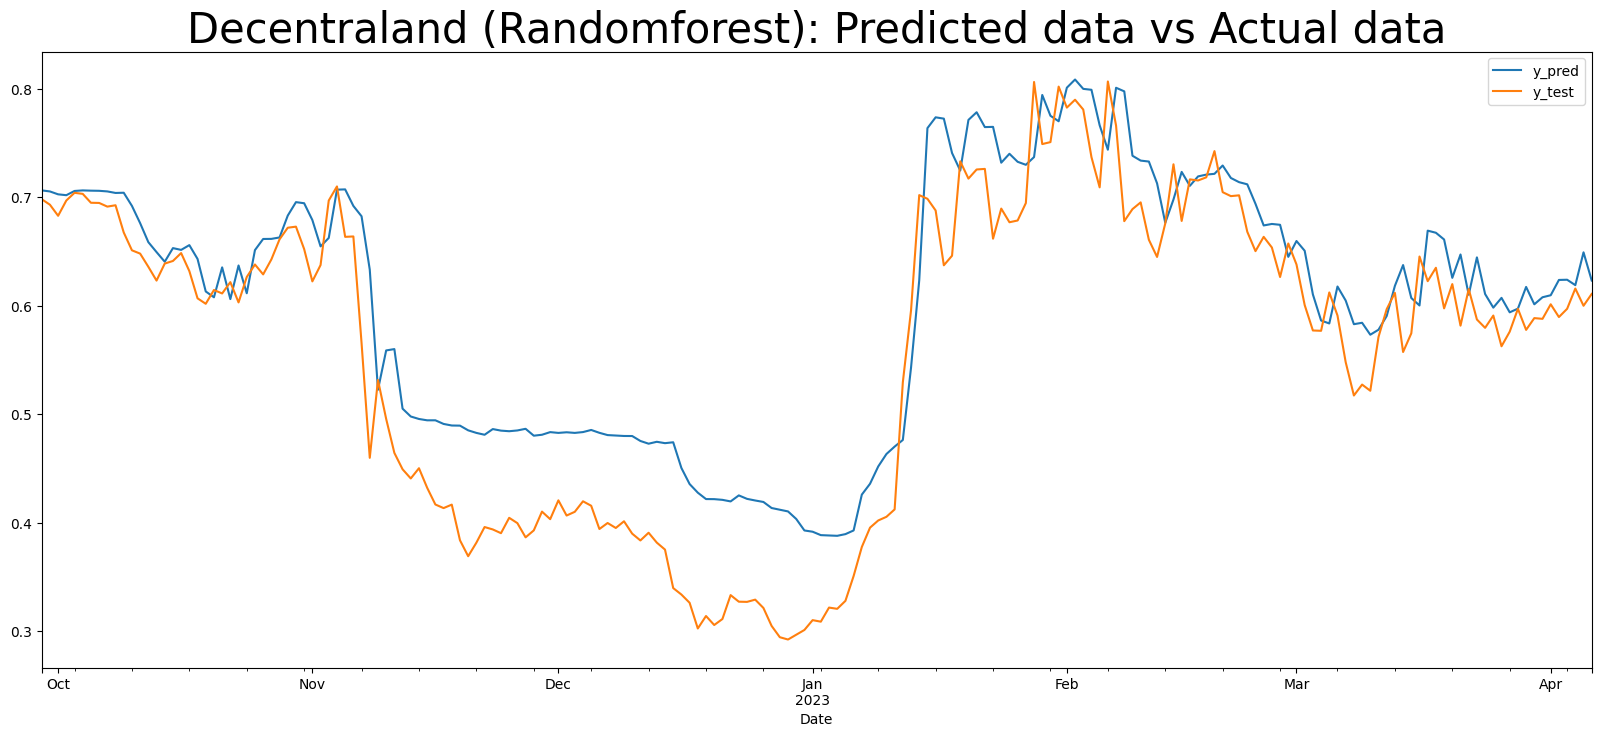

In [ ]:
date = pd.to_datetime(x['Date'], unit='s')[len(x_train):]
results = pd.DataFrame({'Date':date, 'y_pred':y_pred_rf, 'y_test':y_test})
results.set_index('Date', inplace=True)

results.plot(figsize=(20,8))
plt.title('Decentraland (Randomforest): Predicted data vs Actual data',fontsize=30);

<ipython-input-30-7d5b2c20452b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = y_pred_rf


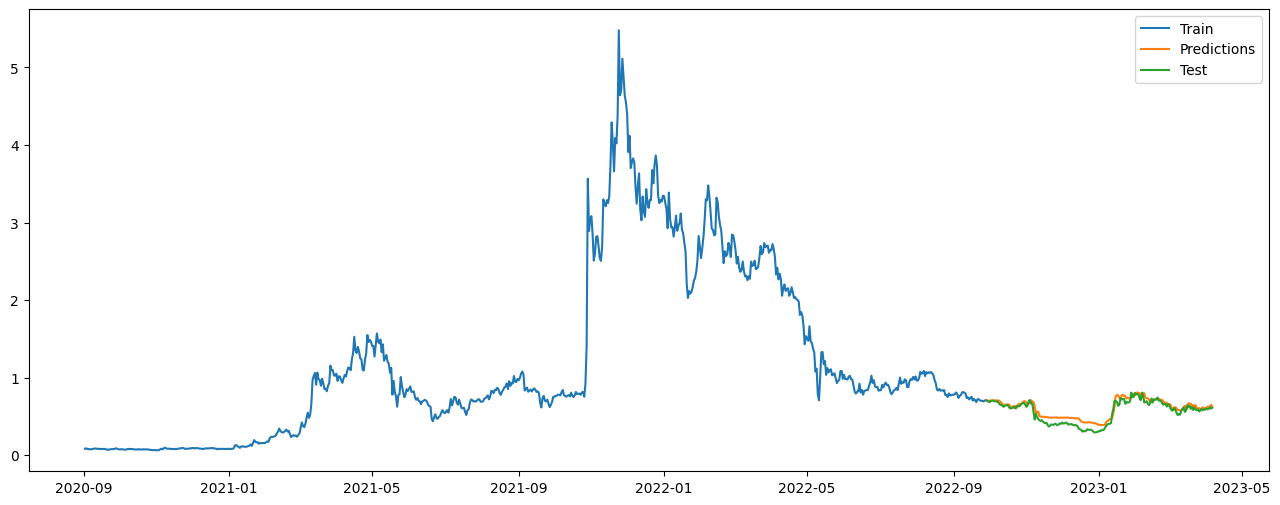

In [ ]:
train = decen[:len(x_train)]
test = decen[len(x_train):]
test['Predictions'] = y_pred_rf

plt.figure(figsize=(16,6))
plt.plot(train['Date'], train[target])
plt.plot(test['Date'], test[['Predictions', target]])
plt.legend(['Train','Predictions', 'Test'], loc = 'upper right');

특성 중요도 확인

In [ ]:
best_model.feature_importances_

array([6.32611805e-03, 1.01685344e-01, 1.81115812e-01, 8.85693883e-02,
       1.64627579e-01, 1.74701752e-01, 3.80986326e-03, 1.13159971e-01,
       2.08716161e-02, 3.83887727e-02, 2.22802972e-02, 3.85168620e-03,
       4.77255871e-03, 1.16660410e-03, 6.69164699e-02, 7.75515165e-03,
       1.01587739e-06])

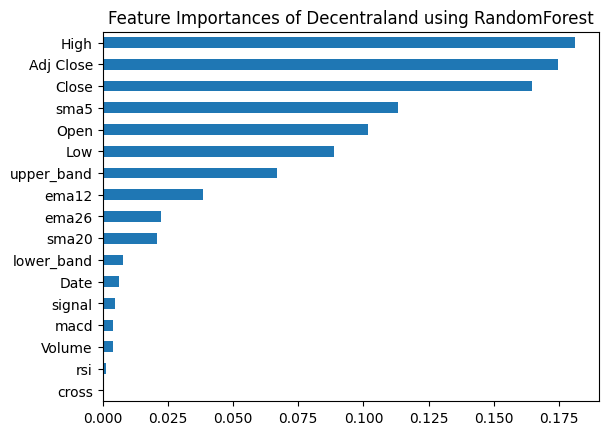

In [ ]:
importances = pd.Series(best_model.feature_importances_, x.columns)
plt.title('Feature Importances of Decentraland using RandomForest')
importances.sort_values().plot.barh();

> 특성 중요도가 낮은 column 제거했을 때가 더 성능이 좋았다!


In [ ]:
target='target_1d'
x = decen.drop(columns=[target, 'target_5d', 'cross','rsi', 'Volume', 'macd', 'signal', 'Date', 'lower_band'], axis=1)
y = decen[target]

x_train, x_test = x[0:int(len(x)*0.8)], x[int(len(x)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

rf2 = RandomForestRegressor(criterion='squared_error',
                              min_samples_split=3,
                              random_state=42,
                              bootstrap=True,
                              oob_score=True,
                              max_features='sqrt')
param_grid = {
    'n_estimators': [1000, 1100, 1200],
    'max_depth': [8,9,10],
    'min_samples_leaf':[2,3,4]
}
grid_search = GridSearchCV(estimator=rf2, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
y_pred_rf2 = best_model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred_rf2)
rmse = mean_squared_error(y_test, y_pred_rf2, squared=False)
r2 = r2_score(y_test, y_pred_rf2)
max_err = max_error(y_test, y_pred_rf2)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Max Error: {max_err:.4f}")

Mean Absolute Error: 0.0414
Root Mean Squared Error: 0.0513
R-squared: 0.8713
Max Error: 0.1608


In [ ]:
best_model

RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=3, n_estimators=1000, oob_score=True,
                      random_state=42)

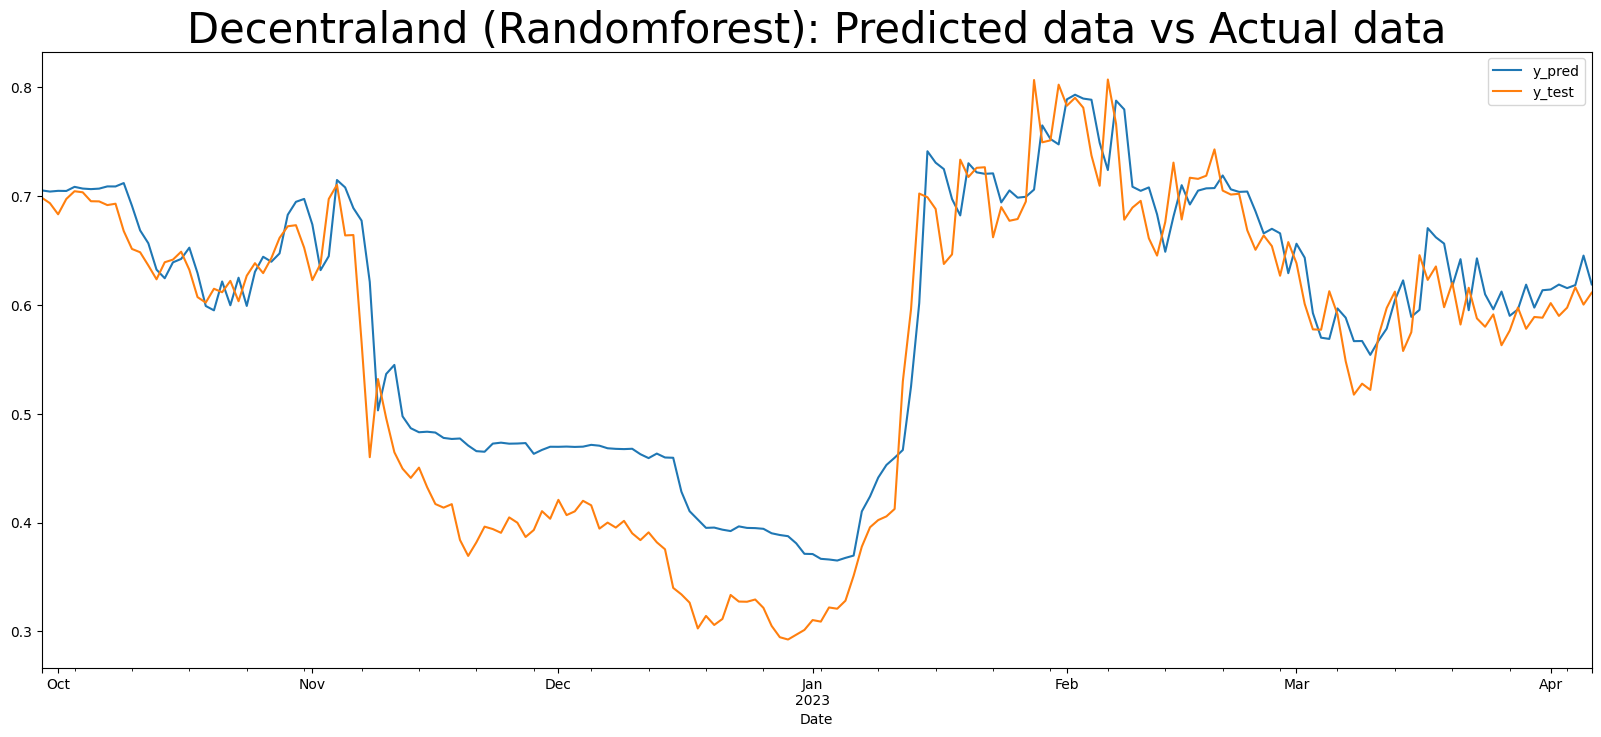

In [ ]:
date = pd.to_datetime(decen['Date'], unit='s')[len(x_train):]
results = pd.DataFrame({'Date':date, 'y_pred':y_pred_rf2, 'y_test':y_test})
results.set_index('Date', inplace=True)

results.plot(figsize=(20,8))
plt.title('Decentraland (Randomforest): Predicted data vs Actual data',fontsize=30);

<ipython-input-39-cb6590206678>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = y_pred_rf2


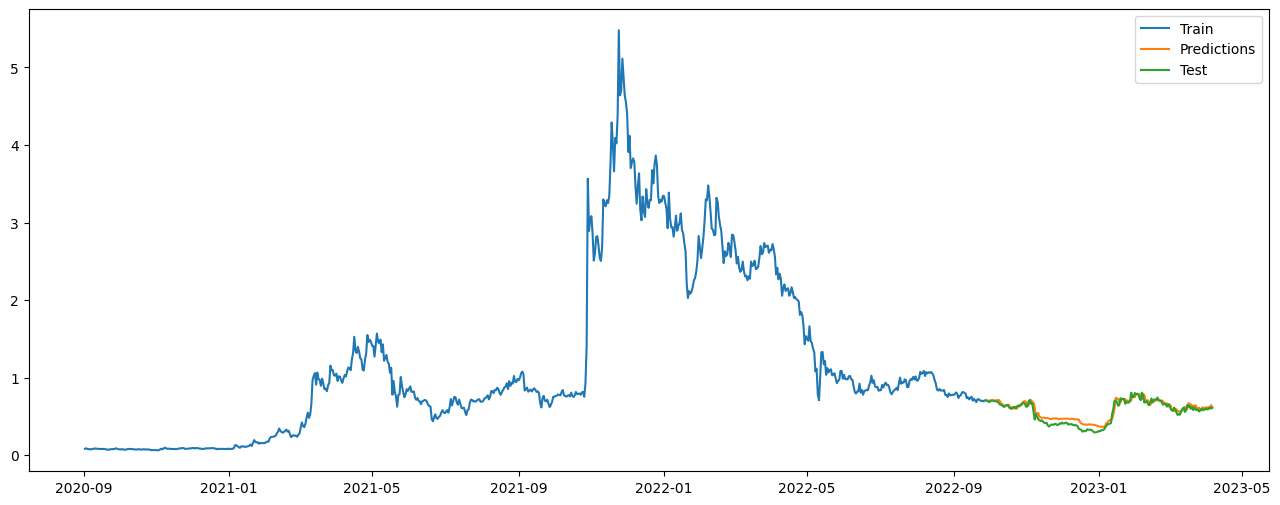

In [ ]:
train = decen[:len(x_train)]
test = decen[len(x_train):]
test['Predictions'] = y_pred_rf2

plt.figure(figsize=(16,6))
plt.plot(train['Date'], train[target])
plt.plot(test['Date'], test[['Predictions', target]])
plt.legend(['Train','Predictions', 'Test'], loc = 'upper right');

5일 뒤의 성능 예측은 어떠할까

In [ ]:
target='target_5d'
x = decen.drop(columns=[target, 'target_1d'], axis=1)
y = decen[target]

# Convert to Unix timestamp
x['Date'] = x['Date'].astype(np.int64) // 10**9

x_train, x_test = x[0:int(len(x)*0.8)], x[int(len(x)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# Initialize model
rf3 = RandomForestRegressor(criterion='squared_error',
                              min_samples_split=3,
                              random_state=42,
                              bootstrap=True,
                              oob_score=True,
                              max_features='sqrt')

# Define parameter grid
param_grid = {
    'n_estimators': [1000, 1100, 1200],
    'max_depth': [8,9,10],
    'min_samples_leaf':[2,3,4]
}

# Initialize GridSearchCV object
grid_search = GridSearchCV(estimator=rf3, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit GridSearchCV object to training data
grid_search.fit(x_train, y_train)

# Extract best model
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred_rf3 = best_model.predict(x_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred_rf3)
rmse = mean_squared_error(y_test, y_pred_rf3, squared=False)
r2 = r2_score(y_test, y_pred_rf3)
max_err = max_error(y_test, y_pred_rf3)

# Print performance metrics
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Max Error: {max_err:.4f}")


Mean Absolute Error: 0.1438
Root Mean Squared Error: 0.1648
R-squared: -0.3492
Max Error: 0.3542


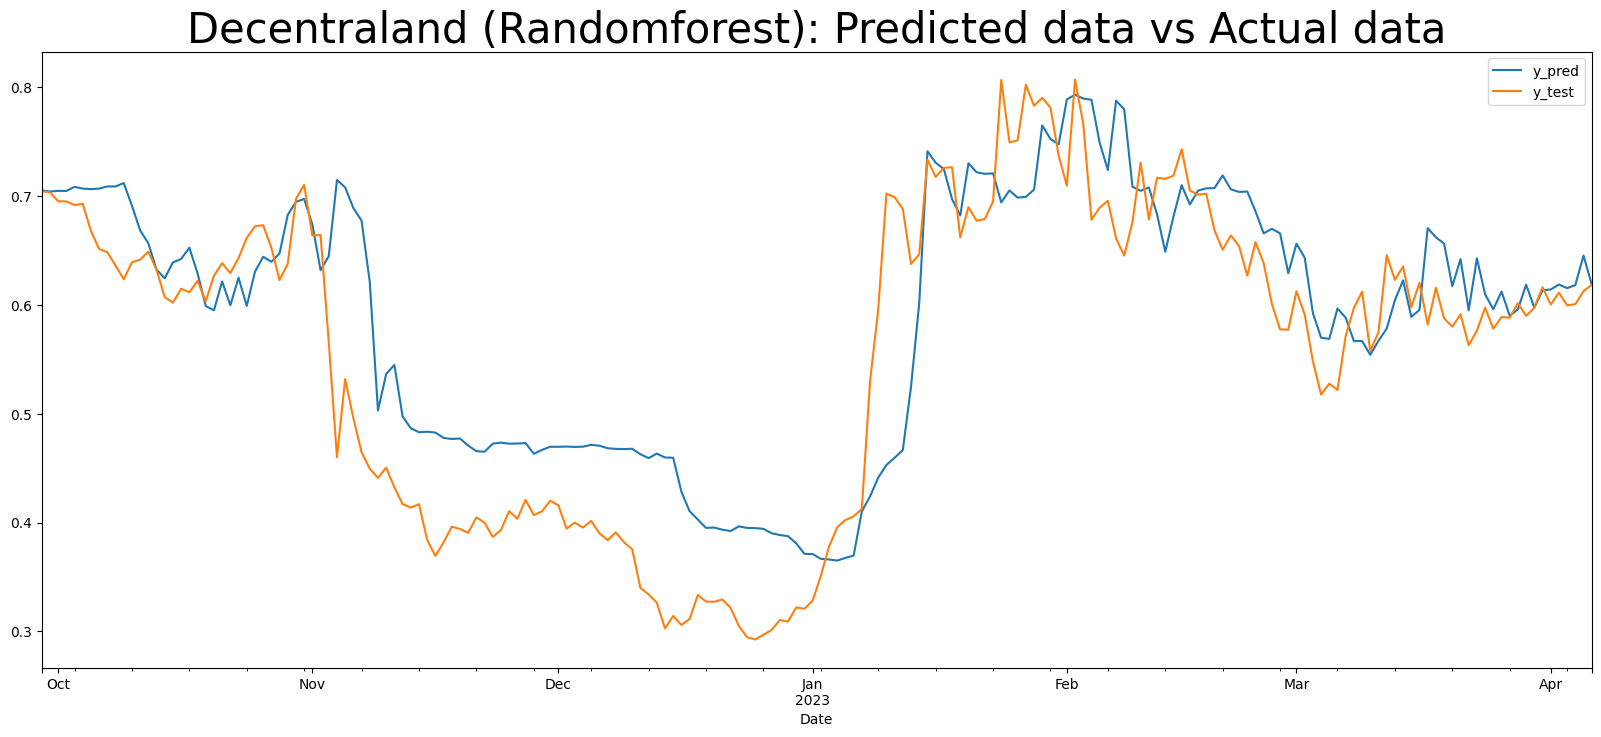

In [ ]:
date = pd.to_datetime(decen['Date'], unit='s')[len(x_train):]
results = pd.DataFrame({'Date':date, 'y_pred':y_pred_rf3, 'y_test':y_test})
results.set_index('Date', inplace=True)

results.plot(figsize=(20,8))
plt.title('Decentraland (Randomforest): Predicted data vs Actual data',fontsize=30);

5일 뒤는 거의 못 맞춤..

## 최종 model : Weighted Average (LSTM, RandomForestRegressor)

lstm , randomforest 가중 평균 시, 성능이 더 올라감

In [ ]:
print(r2_score(y_test, y_pred_lstm))
print(r2_score(y_test,y_pred_rf2))

0.908209022504469
0.8713434596464528


In [ ]:
weights = np.arange(0.01, 1, 0.01)

best_weight = 0
best_rmse = float('inf')
best_r2 = -float('inf')

# Loop through weights and calculate performance metrics
for weight in weights:
    y_pred_total = weight * y_pred_lstm.reshape(-1) + (1 - weight) * y_pred_rf2
    rmse = mean_squared_error(y_test, y_pred_total, squared=False)
    r2 = r2_score(y_test, y_pred_total)
    if rmse < best_rmse:
        best_weight = weight
        best_rmse = rmse
        best_r2 = r2

# Print results
print(f"[최적의 가중치 계수 찾기] \nlstm 가중치 : {best_weight:.4f}, randomforest 가중치 : {1-best_weight:.4f}\n")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best R-squared: {best_r2:.4f}")


[최적의 가중치 계수 찾기] 
lstm 가중치 : 0.6000, randomforest 가중치 : 0.4000

Best RMSE: 0.0359
Best R-squared: 0.9369


In [ ]:
y_pred_total = 0.6*y_pred_lstm.reshape(-1) + 0.4*y_pred_rf2

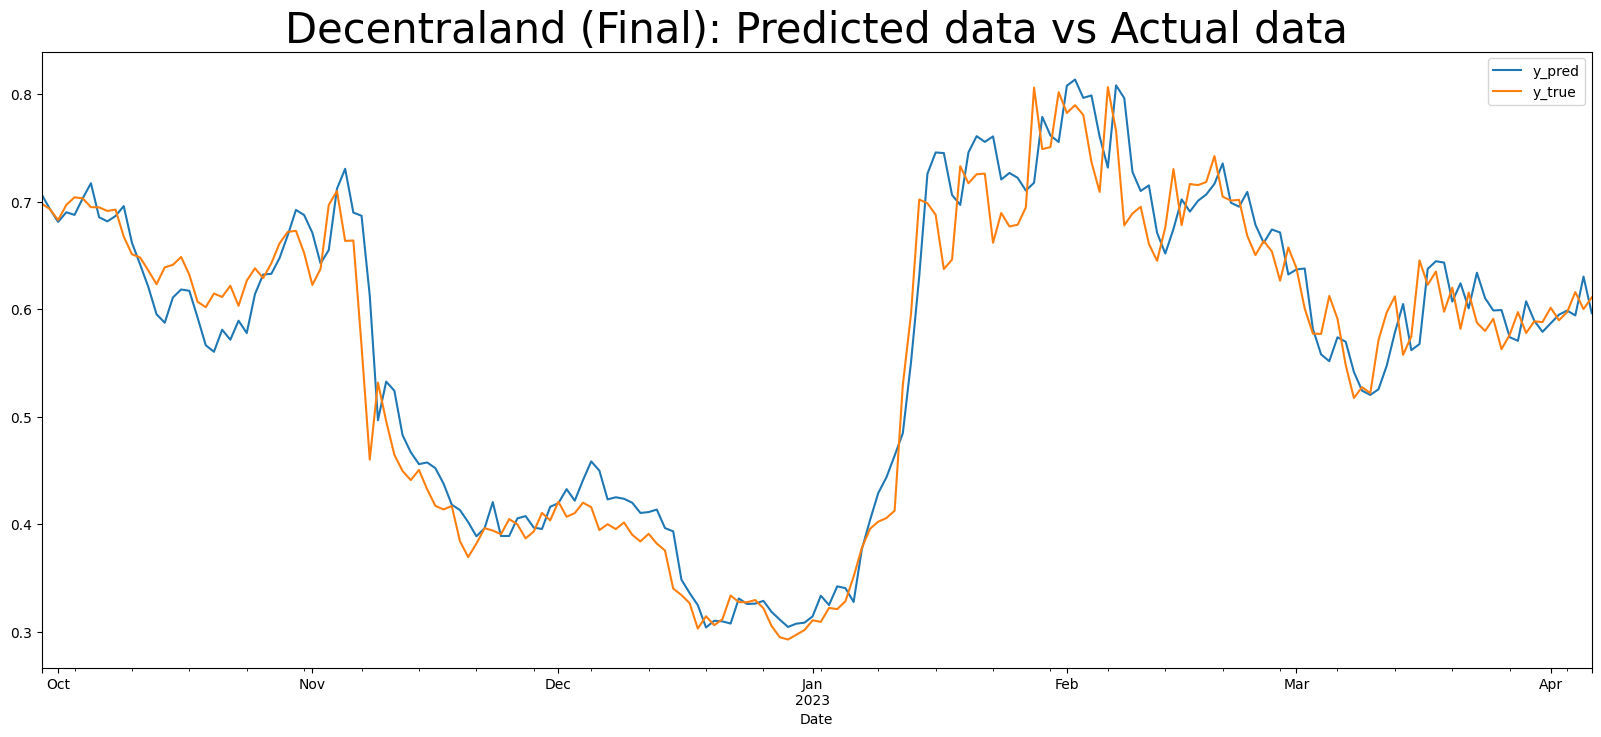

In [ ]:
date = pd.to_datetime(decen['Date'], unit='s')[len(x_train):]
results = pd.DataFrame({'Date': date, 'y_pred': y_pred_total, 'y_true':y_test})
results.set_index('Date', inplace=True)

results.plot(figsize=(20,8))
plt.title('Decentraland (Final): Predicted data vs Actual data',fontsize=30);

<ipython-input-52-3664b06b876f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = y_pred_total


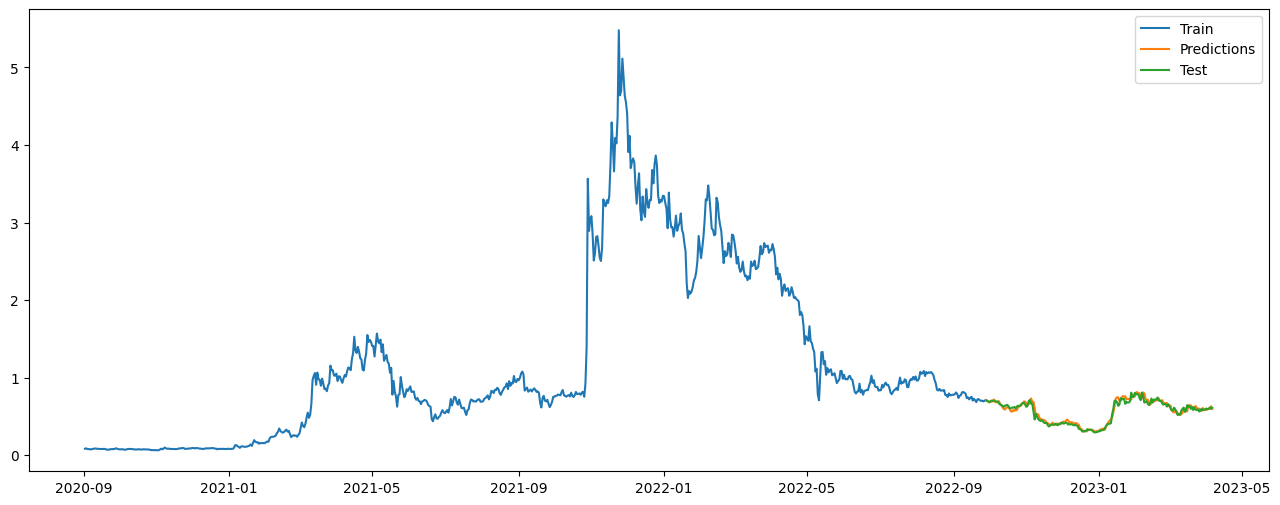

In [ ]:
train = decen[:len(x_train)]
test = decen[len(x_train):]
test['Predictions'] = y_pred_total

plt.figure(figsize=(16,6))
plt.plot(train['Date'], train[target])
plt.plot(test['Date'], test[['Predictions', target]])
plt.legend(['Train','Predictions', 'Test'], loc = 'upper right');

# Sandbox - Modeling



가장 좋은 성능을 내는 모델인 Weighted Average(LSTM, RandomForestRegressor)-> Sandbox 적용

In [ ]:
target='target_1d'
x = sandbox.drop(columns=[target, 'target_5d', 'cross','rsi', 'Volume', 'macd', 'signal', 'Date', 'lower_band'], axis=1)
y = sandbox[target]

x_train, x_test = x[0:int(len(x)*0.8)], x[int(len(x)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

rf2 = RandomForestRegressor(criterion='squared_error',
                              min_samples_split=3,
                              random_state=42,
                              bootstrap=True,
                              oob_score=True,
                              max_features='sqrt')
param_grid = {
    'n_estimators': [1000, 1100, 1200],
    'max_depth': [8,9,10],
    'min_samples_leaf':[2,3,4]
}
grid_search = GridSearchCV(estimator=rf2, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
y_pred_rf2 = best_model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred_rf2)
rmse = mean_squared_error(y_test, y_pred_rf2, squared=False)
r2 = r2_score(y_test, y_pred_rf2)
max_err = max_error(y_test, y_pred_rf2)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Max Error: {max_err:.4f}")

Mean Absolute Error: 0.0289
Root Mean Squared Error: 0.0396
R-squared: 0.9025
Max Error: 0.2012


In [ ]:
target = 'target_1d'
x = sandbox.drop(columns=[target, 'target_5d'], axis=1)
y = sandbox[target]

# Convert to Unix timestamp
x['Date'] = x['Date'].astype(np.int64) // 10**9

# Apply MinMaxScaler to all columns except 'Date'
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x.drop(columns=['Date']))

x_train, x_test = x_scaled[0:int(len(x_scaled)*0.8)], x_scaled[int(len(x_scaled)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]

# Reshape input data to be 3-dimensional
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# Initialize model
lstm = Sequential()
lstm.add(LSTM(50, activation='tanh', input_shape=(1, x_train.shape[2])))
lstm.add(Dense(16, activation="relu"))
lstm.add(Dense(1))

# Compile model
lstm.compile(loss='mse', optimizer='adam')

# Fit model to training data
lstm.fit(x_train, y_train, epochs=50, batch_size=64, verbose=0) 

# Make predictions on test set
y_pred_lstm = lstm.predict(x_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred_lstm)
rmse = mean_squared_error(y_test, y_pred_lstm, squared=False)
r2 = r2_score(y_test, y_pred_lstm)
max_err = max_error(y_test, y_pred_lstm)

# Print performance metrics
print('\nLSTM 다음 날 종가 예측')
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Max Error: {max_err:.4f}")


6/6 [==============================] - 1s 4ms/step

LSTM 다음 날 종가 예측
Mean Absolute Error: 0.0361
Root Mean Squared Error: 0.0503
R-squared: 0.8427
Max Error: 0.2400


In [ ]:
print('sandbox 성능')
print(r2_score(y_test, y_pred_lstm))
print(r2_score(y_test,y_pred_rf2))

sandbox 성능
0.8427416018577868
0.9024832725162448


sandbox에서는 random forest의 성능이 더 좋았다.

In [ ]:
weights = np.arange(0.01, 1, 0.01)

best_weight = 0
best_rmse = float('inf')
best_r2 = -float('inf')

# Loop through weights and calculate performance metrics
for weight in weights:
    y_pred_total = weight * y_pred_lstm.reshape(-1) + (1 - weight) * y_pred_rf2
    rmse = mean_squared_error(y_test, y_pred_total, squared=False)
    r2 = r2_score(y_test, y_pred_total)
    if rmse < best_rmse:
        best_weight = weight
        best_rmse = rmse
        best_r2 = r2

# Print results
print(f"[최적의 가중치 계수 찾기] \nlstm 가중치 : {best_weight:.4f}, randomforest 가중치 : {1-best_weight:.4f}\n")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best R-squared: {best_r2:.4f}")


[최적의 가중치 계수 찾기] 
lstm 가중치 : 0.2200, randomforest 가중치 : 0.7800

Best RMSE: 0.0386
Best R-squared: 0.9074


In [ ]:
y_pred_total = 0.22*y_pred_lstm.reshape(-1) + 0.78*y_pred_rf2

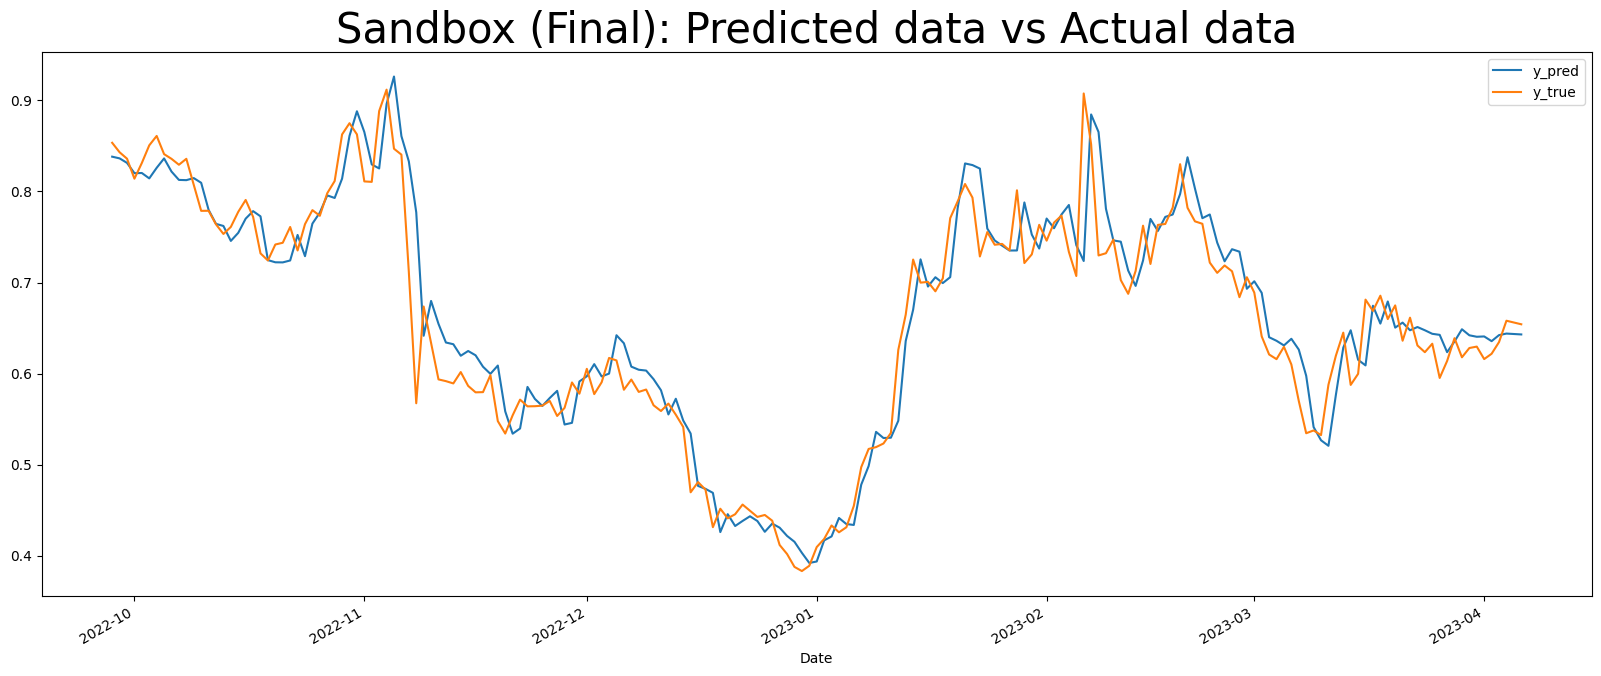

In [ ]:
date = pd.to_datetime(sandbox['Date'], unit='s')[len(x_train):]
results = pd.DataFrame({'Date': date, 'y_pred': y_pred_total, 'y_true':y_test})
results.set_index('Date', inplace=True)

results.plot(figsize=(20,8))
plt.title('Sandbox (Final): Predicted data vs Actual data',fontsize=30);

# Orbcity Modeling

In [ ]:
orb.shape

,Date,Open,High,Low,Close,Adj Close,Volume,sma5,sma20,ema12,ema26,macd,signal,rsi,upper_band,lower_band,cross,target_1d,target_5d
0,2022-04-10,0.437217,0.437499,0.384871,0.388640,0.388640,3495446.0,0.412537,0.423458,0.417801,0.439934,-0.022133,-0.025585,49.980768,0.529546,0.317370,0,0.366286,0.348381
1,2022-04-11,0.388546,0.394728,0.364913,0.366286,0.366286,2455043.0,0.410989,0.415550,0.409876,0.434479,-0.024603,-0.025388,46.789430,0.513182,0.317918,0,0.379134,0.347329
2,2022-04-12,0.366440,0.392020,0.353462,0.379134,0.379134,2169054.0,0.402472,0.409803,0.405146,0.430379,-0.025233,-0.025357,52.518949,0.501313,0.318293,0,0.361330,0.336730
3,2022-04-13,0.379150,0.382842,0.343605,0.361330,0.361330,2731981.0,0.386532,0.403049,0.398405,0.425264,-0.026859,-0.025658,51.596167,0.487299,0.318800,0,0.358279,0.336562
4,2022-04-14,0.361345,0.365375,0.349468,0.358279,0.358279,2325314.0,0.370734,0.397076,0.392232,0.420303,-0.028071,-0.026140,50.778370,0.475787,0.318366,0,0.348381,0.345708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2023-04-01,0.086174,0.086185,0.083886,0.085617,0.085617,198497.0,0.086876,0.097935,0.092746,0.104255,-0.011510,-0.011490,36.799159,0.119269,0.076602,0,0.086403,0.072549
357,2023-04-02,0.085147,0.086990,0.083724,0.086403,0.086403,102489.0,0.086695,0.097311,0.091770,0.102933,-0.011163,-0.011425,29.082715,0.119249,0.075373,0,0.084599,0.072672
358,2023-04-03,0.086400,0.086433,0.082541,0.084599,0.084599,126964.0,0.085543,0.096433,0.090667,0.101575,-0.010908,-0.011321,31.969909,0.118951,0.073914,0,0.084436,0.073519
359,2023-04-04,0.084621,0.087342,0.081928,0.084436,0.084436,252447.0,0.085443,0.095713,0.089708,0.100305,-0.010597,-0.011177,34.665833,0.118822,0.072604,0,0.082614,0.072935


In [ ]:
target='target_1d'
x = orb.drop(columns=[target, 'target_5d', 'cross','rsi', 'Volume', 'macd', 'signal', 'Date', 'lower_band'], axis=1)
y = orb[target]

x_train, x_test = x[0:int(len(x)*0.8)], x[int(len(x)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

rf2 = RandomForestRegressor(criterion='squared_error',
                              min_samples_split=3,
                              random_state=42,
                              bootstrap=True,
                              oob_score=True,
                              max_features='sqrt')
param_grid = {
    'n_estimators': [1000, 1100, 1200],
    'max_depth': [8,9,10],
    'min_samples_leaf':[2,3,4]
}
grid_search = GridSearchCV(estimator=rf2, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
y_pred_rf2 = best_model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred_rf2)
rmse = mean_squared_error(y_test, y_pred_rf2, squared=False)
r2 = r2_score(y_test, y_pred_rf2)
max_err = max_error(y_test, y_pred_rf2)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Max Error: {max_err:.4f}")

Mean Absolute Error: 0.0133
Root Mean Squared Error: 0.0178
R-squared: 0.7189
Max Error: 0.0625


In [ ]:
target = 'target_1d'
x = orb.drop(columns=[target, 'target_5d'], axis=1)
y = orb[target]

# Convert to Unix timestamp
x['Date'] = x['Date'].astype(np.int64) // 10**9

# Apply MinMaxScaler to all columns except 'Date'
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x.drop(columns=['Date']))

x_train, x_test = x_scaled[0:int(len(x_scaled)*0.8)], x_scaled[int(len(x_scaled)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]

# Reshape input data to be 3-dimensional
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# Initialize model
lstm = Sequential()
lstm.add(LSTM(50, activation='tanh', input_shape=(1, x_train.shape[2])))
lstm.add(Dense(16, activation="relu"))
lstm.add(Dense(1))

# Compile model
lstm.compile(loss='mse', optimizer='adam')

# Fit model to training data
lstm.fit(x_train, y_train, epochs=50, batch_size=64, verbose=0) 

# Make predictions on test set
y_pred_lstm = lstm.predict(x_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred_lstm)
rmse = mean_squared_error(y_test, y_pred_lstm, squared=False)
r2 = r2_score(y_test, y_pred_lstm)
max_err = max_error(y_test, y_pred_lstm)

# Print performance metrics
print('\nLSTM 다음 날 종가 예측')
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Max Error: {max_err:.4f}")


3/3 [==============================] - 0s 4ms/step

LSTM 다음 날 종가 예측
Mean Absolute Error: 0.0118
Root Mean Squared Error: 0.0165
R-squared: 0.7569
Max Error: 0.0661


In [ ]:
print('orbcity 성능')
print(r2_score(y_test, y_pred_lstm))
print(r2_score(y_test,y_pred_rf2))

orbcity 성능
0.7568758755796425
0.7188555411209573


In [ ]:
weights = np.arange(0.01, 1, 0.01)

best_weight = 0
best_rmse = float('inf')
best_r2 = -float('inf')

# Loop through weights and calculate performance metrics
for weight in weights:
    y_pred_total = weight * y_pred_lstm.reshape(-1) + (1 - weight) * y_pred_rf2
    rmse = mean_squared_error(y_test, y_pred_total, squared=False)
    r2 = r2_score(y_test, y_pred_total)
    if rmse < best_rmse:
        best_weight = weight
        best_rmse = rmse
        best_r2 = r2

# Print results
print(f"[최적의 가중치 계수 찾기] \nlstm 가중치 : {best_weight:.4f}, randomforest 가중치 : {1-best_weight:.4f}\n")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best R-squared: {best_r2:.4f}")


[최적의 가중치 계수 찾기] 
lstm 가중치 : 0.5800, randomforest 가중치 : 0.4200

Best RMSE: 0.0151
Best R-squared: 0.7964


In [ ]:
y_pred_total = 0.58*y_pred_lstm.reshape(-1) + 0.42*y_pred_rf2

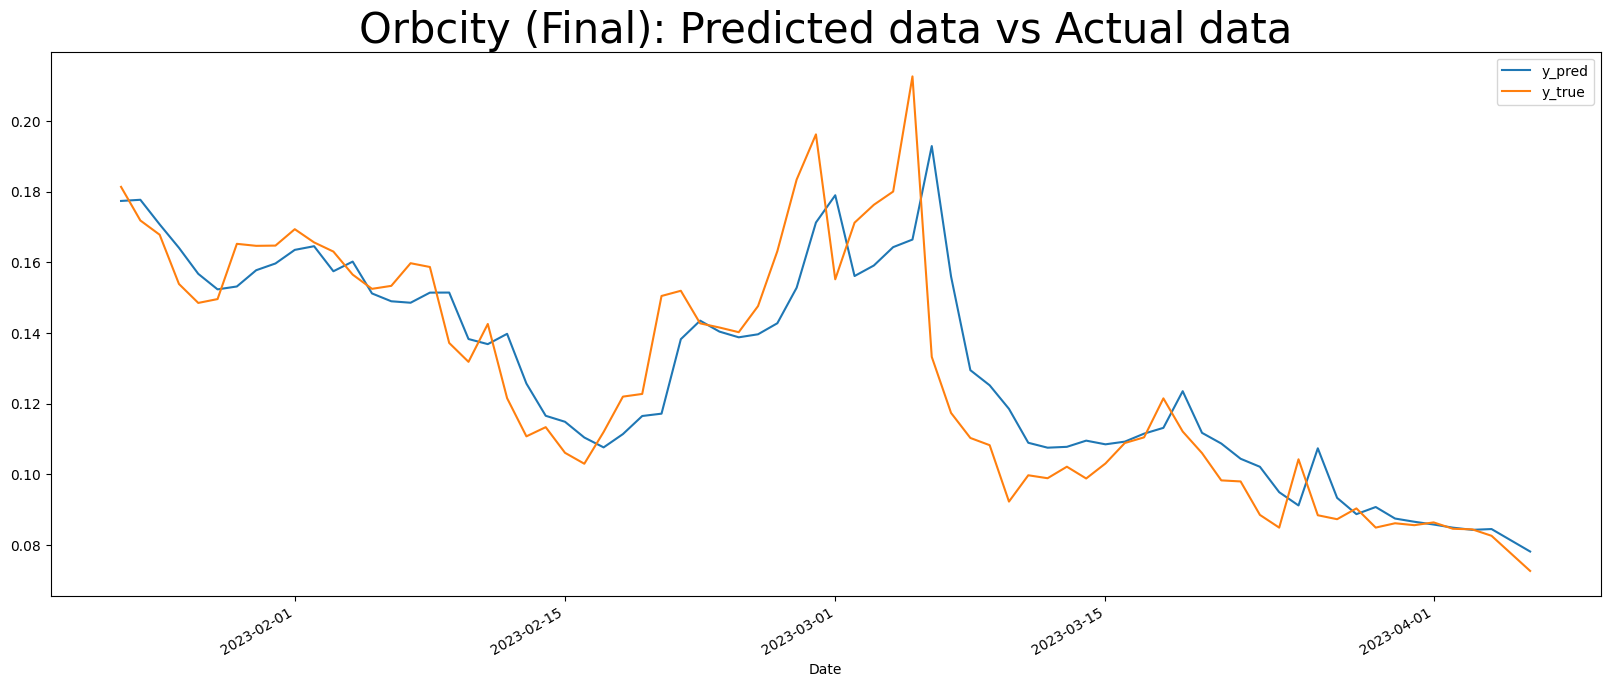

In [ ]:
date = pd.to_datetime(orb['Date'], unit='s')[len(x_train):]
results = pd.DataFrame({'Date': date, 'y_pred': y_pred_total, 'y_true':y_test})
results.set_index('Date', inplace=True)

results.plot(figsize=(20,8))
plt.title('Orbcity (Final): Predicted data vs Actual data',fontsize=30);

데이터의 부족으로 성능이 낮다.  
대량주의 과거 데이터를 이용하여 orbcity 예측해볼까?


가정 ) Orbcity의 토지 nft도 과거 토지 데이터의 분포와 비슷하다고 가정.

In [14]:
pred_decen = decen[decen['Date']<'2022-04-10']
df = pd.concat([pred_decen, orb], ignore_index=True )

In [16]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,sma5,sma20,ema12,ema26,macd,signal,rsi,upper_band,lower_band,cross,target_1d,target_5d
0,2020-09-02,0.100694,0.104012,0.091389,0.100446,0.100446,60876653.0,0.102387,0.095670,0.097948,0.090376,0.007572,0.008414,64.688549,0.108853,0.082487,0,0.082960,0.076879
1,2020-09-03,0.100560,0.101295,0.082528,0.082960,0.082960,51053790.0,0.097292,0.095054,0.095642,0.089826,0.005816,0.007894,44.008498,0.109412,0.080695,0,0.088212,0.074365
2,2020-09-04,0.082707,0.090225,0.081716,0.088212,0.088212,52366483.0,0.094249,0.094541,0.094499,0.089707,0.004792,0.007274,45.729136,0.109117,0.079965,1,0.078609,0.077438
3,2020-09-05,0.088227,0.089837,0.072696,0.078609,0.078609,56039022.0,0.090226,0.093541,0.092055,0.088885,0.003170,0.006453,38.296774,0.109610,0.077472,0,0.078271,0.082078
4,2020-09-06,0.078609,0.081143,0.073036,0.078271,0.078271,37722033.0,0.085700,0.092675,0.089934,0.088099,0.001835,0.005529,40.532605,0.110089,0.075261,0,0.076879,0.085089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,2023-04-01,0.086174,0.086185,0.083886,0.085617,0.085617,198497.0,0.086876,0.097935,0.092746,0.104255,-0.011510,-0.011490,36.799159,0.119269,0.076602,0,0.086403,0.072549
942,2023-04-02,0.085147,0.086990,0.083724,0.086403,0.086403,102489.0,0.086695,0.097311,0.091770,0.102933,-0.011163,-0.011425,29.082715,0.119249,0.075373,0,0.084599,0.072672
943,2023-04-03,0.086400,0.086433,0.082541,0.084599,0.084599,126964.0,0.085543,0.096433,0.090667,0.101575,-0.010908,-0.011321,31.969909,0.118951,0.073914,0,0.084436,0.073519
944,2023-04-04,0.084621,0.087342,0.081928,0.084436,0.084436,252447.0,0.085443,0.095713,0.089708,0.100305,-0.010597,-0.011177,34.665833,0.118822,0.072604,0,0.082614,0.072935


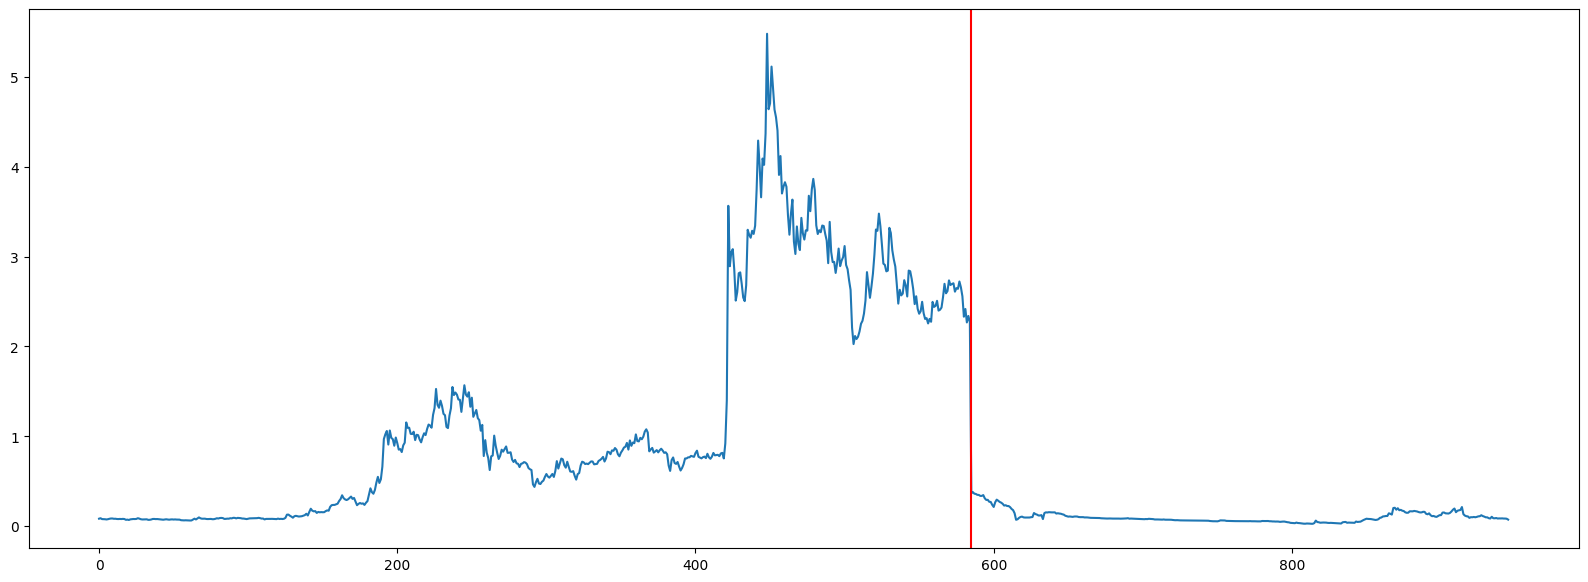

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(df[target])
plt.axvline(585, color='red')

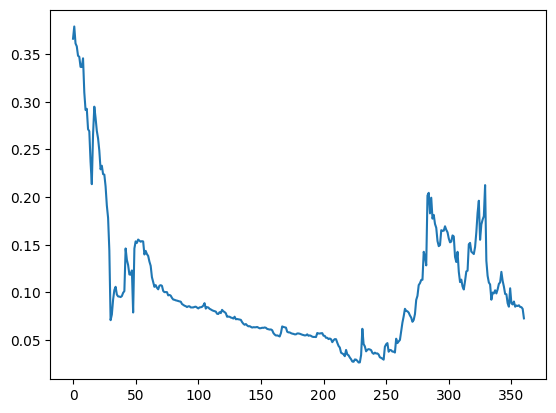

In [ ]:
plt.plot(orb[target])

In [ ]:
# RandomForest
target='target_1d'
x = df.drop(columns=[target, 'target_5d', 'cross','rsi', 'Volume', 'macd', 'signal', 'Date', 'lower_band'], axis=1)
y = df[target]

x_train, x_test = x[0:int(len(x)*0.8)], x[int(len(x)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

rf2 = RandomForestRegressor(criterion='squared_error',
                              min_samples_split=3,
                              random_state=42,
                              bootstrap=True,
                              oob_score=True,
                              max_features='sqrt')
param_grid = {
    'n_estimators': [1000, 1100, 1200],
    'max_depth': [8,9,10],
    'min_samples_leaf':[2,3,4]
}
grid_search = GridSearchCV(estimator=rf2, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
y_pred_rf2 = best_model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred_rf2)
rmse = mean_squared_error(y_test, y_pred_rf2, squared=False)
r2 = r2_score(y_test, y_pred_rf2)
max_err = max_error(y_test, y_pred_rf2)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Max Error: {max_err:.4f}")

Mean Absolute Error: 0.0111
Root Mean Squared Error: 0.0160
R-squared: 0.8923
Max Error: 0.0782


In [ ]:
# LSTM
target = 'target_1d'
x = df.drop(columns=[target, 'target_5d'], axis=1)
y = df[target]

# Convert to Unix timestamp
x['Date'] = x['Date'].astype(np.int64) // 10**9

# Apply MinMaxScaler to all columns except 'Date'
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x.drop(columns=['Date']))

x_train, x_test = x_scaled[0:int(len(x_scaled)*0.8)], x_scaled[int(len(x_scaled)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]

# Reshape input data to be 3-dimensional
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# Initialize model
lstm = Sequential()
lstm.add(LSTM(50, activation='tanh', input_shape=(1, x_train.shape[2])))
lstm.add(Dense(16, activation="relu"))
lstm.add(Dense(1))

# Compile model
lstm.compile(loss='mse', optimizer='adam')

# Fit model to training data
lstm.fit(x_train, y_train, epochs=50, batch_size=64, verbose=0) 

# Make predictions on test set
y_pred_lstm = lstm.predict(x_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred_lstm)
rmse = mean_squared_error(y_test, y_pred_lstm, squared=False)
r2 = r2_score(y_test, y_pred_lstm)
max_err = max_error(y_test, y_pred_lstm)

# Print performance metrics
print('\nLSTM 다음 날 종가 예측')
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Max Error: {max_err:.4f}")


6/6 [==============================] - 0s 3ms/step

LSTM 다음 날 종가 예측
Mean Absolute Error: 0.0173
Root Mean Squared Error: 0.0216
R-squared: 0.8033
Max Error: 0.0819


In [ ]:
print('orbcity 성능')
print(r2_score(y_test, y_pred_lstm))
print(r2_score(y_test,y_pred_rf2))

orbcity 성능
0.8033216599711426
0.892286170690695


In [ ]:
weights = np.arange(0.01, 1, 0.01)

best_weight = 0
best_rmse = float('inf')
best_r2 = -float('inf')

# Loop through weights and calculate performance metrics
for weight in weights:
    y_pred_total = weight * y_pred_lstm.reshape(-1) + (1 - weight) * y_pred_rf2
    rmse = mean_squared_error(y_test, y_pred_total, squared=False)
    r2 = r2_score(y_test, y_pred_total)
    if rmse < best_rmse:
        best_weight = weight
        best_rmse = rmse
        best_r2 = r2

# Print results
print(f"[최적의 가중치 계수 찾기] \nlstm 가중치 : {best_weight:.4f}, randomforest 가중치 : {1-best_weight:.4f}\n")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best R-squared: {best_r2:.4f}")


[최적의 가중치 계수 찾기] 
lstm 가중치 : 0.2800, randomforest 가중치 : 0.7200

Best RMSE: 0.0147
Best R-squared: 0.9083


In [ ]:
y_pred_total = 0.28*y_pred_lstm.reshape(-1) + 0.72*y_pred_rf2

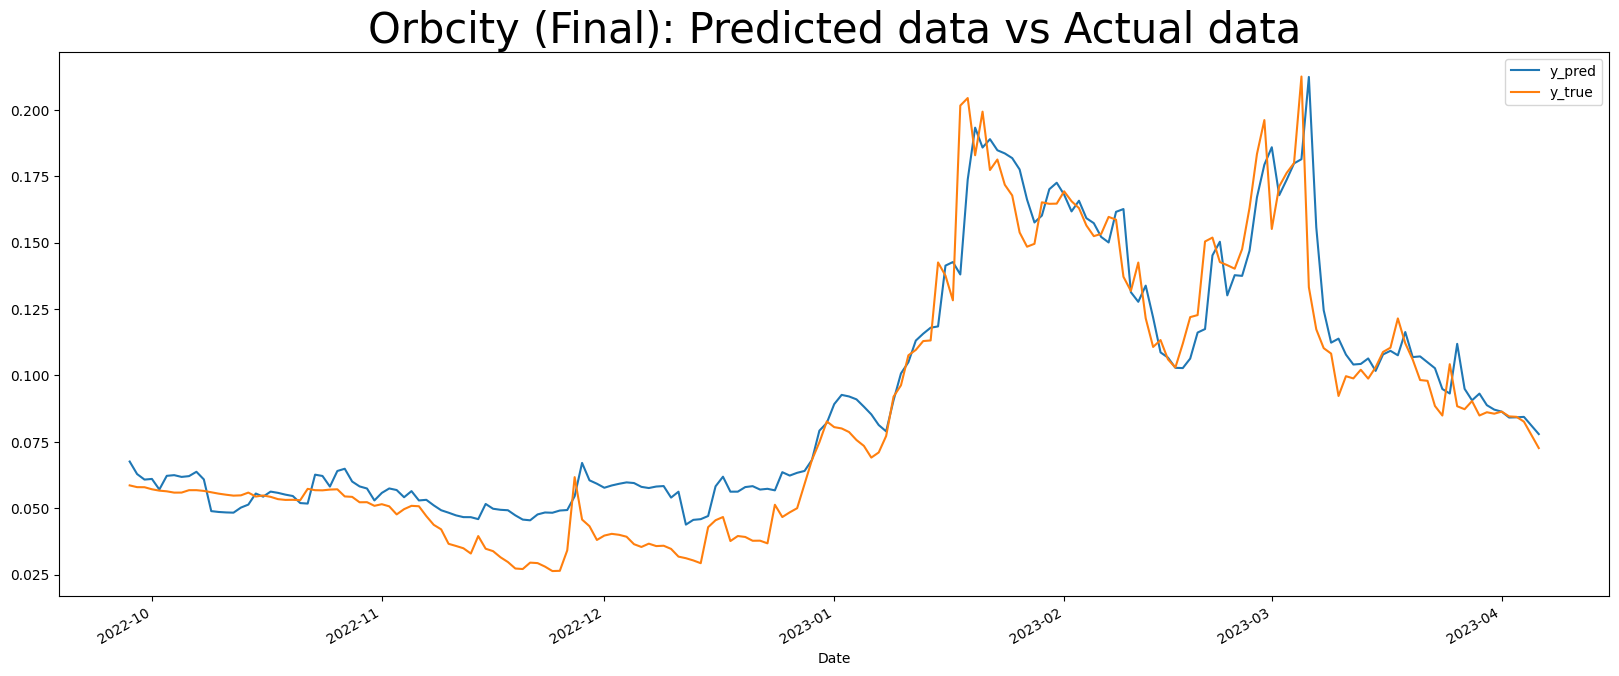

In [ ]:
date = pd.to_datetime(df['Date'], unit='s')[len(x_train):]
results = pd.DataFrame({'Date': date, 'y_pred': y_pred_total, 'y_true':y_test})
results.set_index('Date', inplace=True)

results.plot(figsize=(20,8))
plt.title('Orbcity (Final): Predicted data vs Actual data',fontsize=30);

<ipython-input-224-f2f3005f6ad5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = y_pred_total


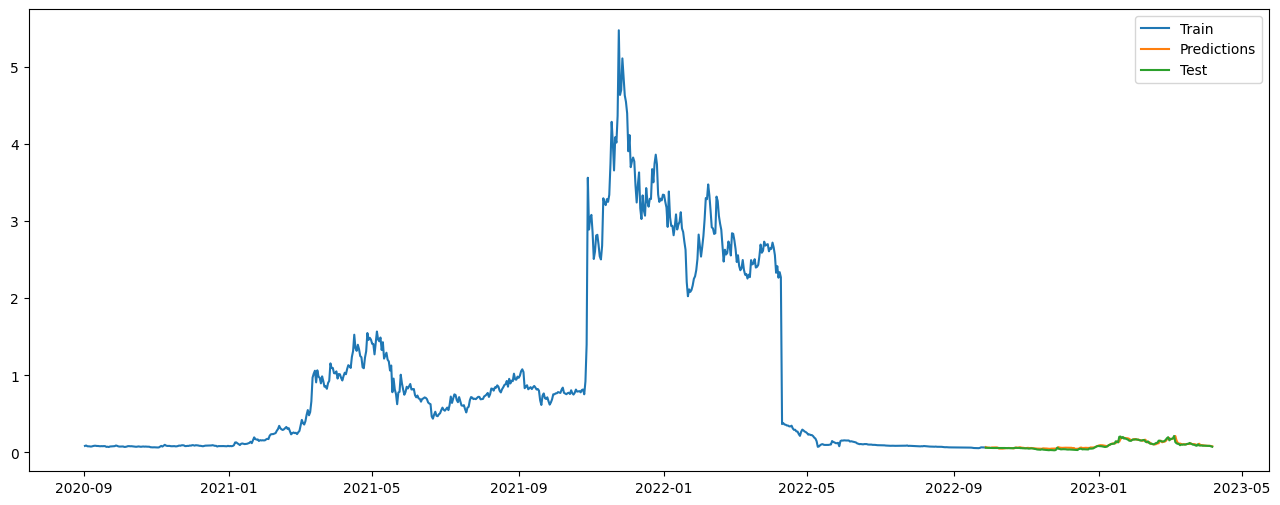

In [ ]:
train = df[:len(x_train)]
test = df[len(x_train):]
test['Predictions'] = y_pred_total

plt.figure(figsize=(16,6))
plt.plot(train['Date'], train[target])
plt.plot(test['Date'], test[['Predictions', target]])
plt.legend(['Train','Predictions', 'Test'], loc = 'upper right');